<캡스톤 6번 데이터 분석>

1. 구조파악
2. 의료보험 청구 비용 시각화
3. EDA
 - 3-1 성별, 흡연 여부, 지역 의료비 결정에 결정적인 역할을 할까?
 - 3-2 그렇다면 흡연율은?
 - 3-3 그렇다면 가장 크게 작용하는 변수는?
 - 3-4 상관분석
 - 3-4-2 “어떤 변수가 의료비와 가장 가까울까?”

4. 회귀분석
4-1 연령구간 별 의료보험 청구 비용의 차이가 있을까?
4-2.  “모형 진단과 개선”
5. 해석

### 라이브러리 참조

In [153]:
# 라이브러리 기본 참조
from hossam import load_data
from hossam import *
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from pandas.api.types import CategoricalDtype
import pandas as pd
from scipy.stats import t, normaltest, bartlett, levene, ttest_ind
import pingouin as pg
from pandas import DataFrame, get_dummies
# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson


# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor


from statannotations.Annotator import Annotator

# 로지스틱을 위한 참조
import statsmodels.api as sm

from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt


from sklearn.preprocessing import RobustScaler

# 로지스틱 결과 판별을 위한 참조
# → 머신러닝 라이브러리를 미리 사용
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)



# 가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene


# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova


# 사후검정을 위한 라이브러리
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell



import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

### 데이터 불러오기

In [154]:
origin = load_data('insurance')

print("\n==== 데이터 크기 확인 ====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n==== 타입확인 ====")
print(origin.info())


[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

변수명    의미(설명)
--------  ---------------------------------------------------------------
age       가입자의 나이(세).
sex       성별 (male, female).
bmi       체질량 지수(Body Mass Index).
children  부양 자녀 수(보험 내 자녀 수).
smoker    흡연 여부 (yes / no).
region    미국 내 거주 지역 (northeast, northwest, southeast, southwest).
charges   의료보험 청구 비용(달러). 예측해야 하는 타깃 변수.


==== 데이터 크기 확인 ====
데이터셋 크기: (1338, 7)
열 개수: 7
행 개수: 1338

==== 타입확인 ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  

### 데이터 확인

In [155]:
origin.head(100)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
95,28,female,37.620,1,no,southeast,3766.88380
96,54,female,30.800,3,no,southwest,12105.32000
97,55,male,38.280,0,no,southeast,10226.28420
98,56,male,19.950,0,yes,northeast,22412.64850


### STEP 1. 구조파악

<요약>
1. 결측치/이상치/편향 점검
 - 모든 변수에서 결측치 0건 (0%) . 데이터 손실, 보간, 삭제 불필요

2. charges 변수 확인 
 - charges 변수에서 음수 값은 관찰되지 않았으며, 의료비 데이터로서 논리적으로 타당한 범위를 유지
 - 분포가 오른쪽으로 강하게 치우쳐 있다.
 - 낮은 의료비 구간에 관측치가 밀집되어 있고, 고액 의료비는 소수만 존재한다.
 - 분포의 오른쪽 꼬리가 길게 늘어져 있다.

3. age 변수 확인 
 - 전체 범위(약 18~64세)에 걸쳐 관측치가 고르게 분포한다.
 - 특정 연령대에 데이터가 급격히 집중되거나 비어 있는 구간은 보이지 않는다.
 - 분포 형태는 비교적 평탄하며 극단적인 왜도는 관찰되지 않는다.
  
4. bmi 변수 확인 
 - 상위 극단값은 존재하나, 현실적 범위 내로 판단
 -  단봉형 분포를 보이며, 중심은 약 30 전후에 위치한다.
 - 오른쪽으로 약간 치우친 형태를 가진다.
 - 매우 낮거나 매우 높은 bmi 값은 소수만 존재한다.


5. children 변수 확인 
 - 이산적인 값(0, 1, 2, …)에서만 관측치가 나타난다.
 - 0명의 자녀를 가진 경우가 가장 많다.
 - 자녀 수가 증가할수록 관측 빈도가 감소한다.

6. 범주형 변수 비중 확인 (sex, smoker, region)

 | 변수     | 범주 수 | 분포 특성         | 편향 여부 |
| ------ | ---- | ------------- | ----- |
| sex    | 2    | 각 성별 거의 50%로 균등         | 없음    |
| smoker | 2    | non-smoker 가 약 80%로 우세 | 불균형 존재    |
| region | 4    | 각 지역마다 24-27%로 균등            | 균등한편    |

In [156]:
df_nullcheck=origin.copy()

- 모든 변수에서 결측치 0건 (0%) . 데이터 손실, 보간, 삭제 불필요

In [157]:
df_nullcheck.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

- 누락 비율 확인

In [158]:
df_nullcheck.isna().mean() * 100

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [159]:
df_nullcheck[['age', 'bmi', 'charges']].describe()

,age,bmi,charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,13270.422265
std,14.049960,6.098187,12110.011237
min,18.000000,15.960000,1121.873900
25%,27.000000,26.296250,4740.287150
50%,39.000000,30.400000,9382.033000
75%,51.000000,34.693750,16639.912515
max,64.000000,53.130000,63770.428010


- charges 음수 여부
확인 결과 : charges 변수에서 음수 값은 관찰되지 않았으며, 의료비 데이터로서 논리적으로 타당한 범위를 유지하고 있다.

In [160]:
(df_nullcheck['charges'] < 0).sum()


np.int64(0)

- 연속형 데이터(age,bmi,charges) 와 범주형 데이터 (sex , children, smoker, region) 를 분리하여 시각화 해보자

In [161]:
df_plot=origin.copy()

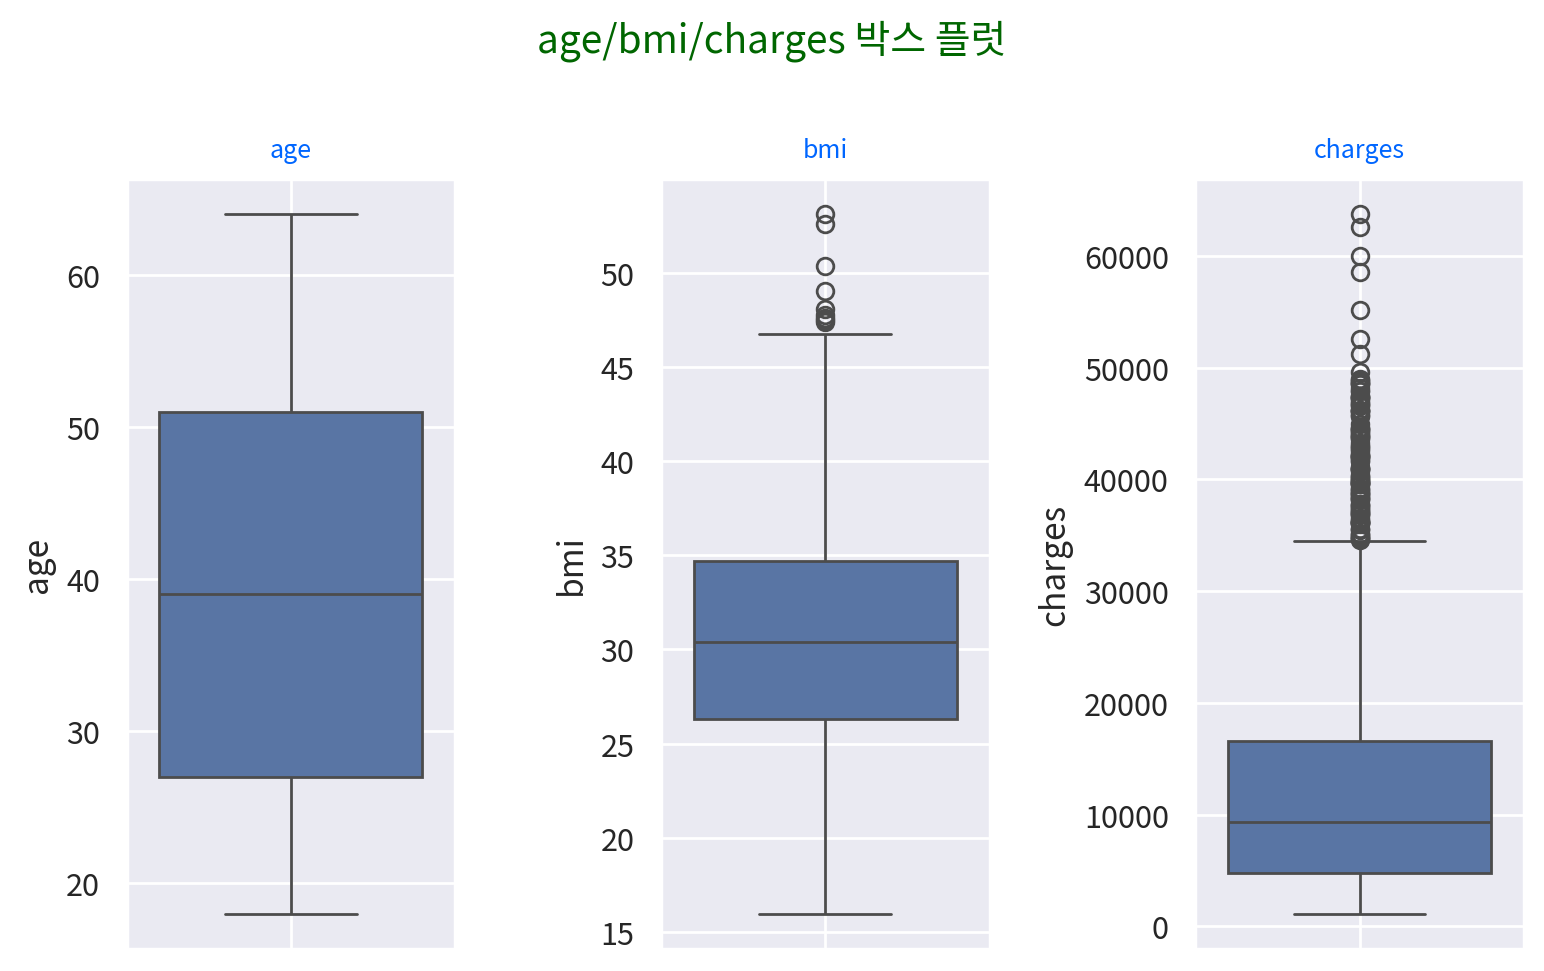

In [162]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1600              # 가로 크기 늘림
height_px = 1000              # 세로 크기 줄임 (1행)
rows = 1
cols = 3
figsize = (width_px / 200, height_px / 200)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=200)

# 2) boxplot 그리기
sb.boxplot(data=df_plot, y='age', ax=ax[0])
sb.boxplot(data=df_plot, y='bmi', ax=ax[1])   # ✅ carat 추가
sb.boxplot(data=df_plot, y='charges', ax=ax[2])


# 3) 그래프 꾸미기
fig.suptitle('age/bmi/charges 박스 플럿', fontsize=14, color='#006600')

fig.subplots_adjust(wspace=0.3)

titles = ['age', 'bmi', 'charges']

for i in range(3):
    ax[i].set_title(titles[i], color="#0066ff", fontsize=9, pad=8)
    ax[i].grid()

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


- 범주형 데이터 (sex , children, smoker, region)

In [163]:
def make_category_summary(df, col):
    """
    범주형 변수(col)에 대해
    count / ratio / percent 요약 데이터프레임 생성
    """
    value_list = df[col].unique()
    counts = []

    for v in value_list:
        counts.append(len(df.query(f"{col} == @v")))

    summary_df = pd.DataFrame({
        col: value_list,
        'count': counts
    })

    total = summary_df['count'].sum()
    summary_df['ratio'] = summary_df['count'] / total
    summary_df['percent'] = (summary_df['ratio'] * 100).round(2)

    return summary_df


In [164]:
sex_df      = make_category_summary(df_plot, 'sex')
children_df = make_category_summary(df_plot, 'children')
smoker_df   = make_category_summary(df_plot, 'smoker')
region_df   = make_category_summary(df_plot, 'region')


In [165]:
sex_df

,sex,count,ratio,percent
0,female,662,0.494768,49.48
1,male,676,0.505232,50.52


In [166]:
children_df

,children,count,ratio,percent
0,0,574,0.428999,42.90
1,1,324,0.242152,24.22
2,3,157,0.117339,11.73
3,2,240,0.179372,17.94
4,5,18,0.013453,1.35
5,4,25,0.018685,1.87


In [167]:
smoker_df


,smoker,count,ratio,percent
0,yes,274,0.204783,20.48
1,no,1064,0.795217,79.52


In [168]:
region_df

,region,count,ratio,percent
0,southwest,325,0.242900,24.29
1,southeast,364,0.272048,27.20
2,northwest,325,0.242900,24.29
3,northeast,324,0.242152,24.22


C:\Users\itwill\AppData\Local\Temp\ipykernel_396\1965110003.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(
C:\Users\itwill\AppData\Local\Temp\ipykernel_396\1965110003.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(
C:\Users\itwill\AppData\Local\Temp\ipykernel_396\1965110003.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(
C:\Users\itwill\AppData\Local\Temp\ipykernel_396\1965110003.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and

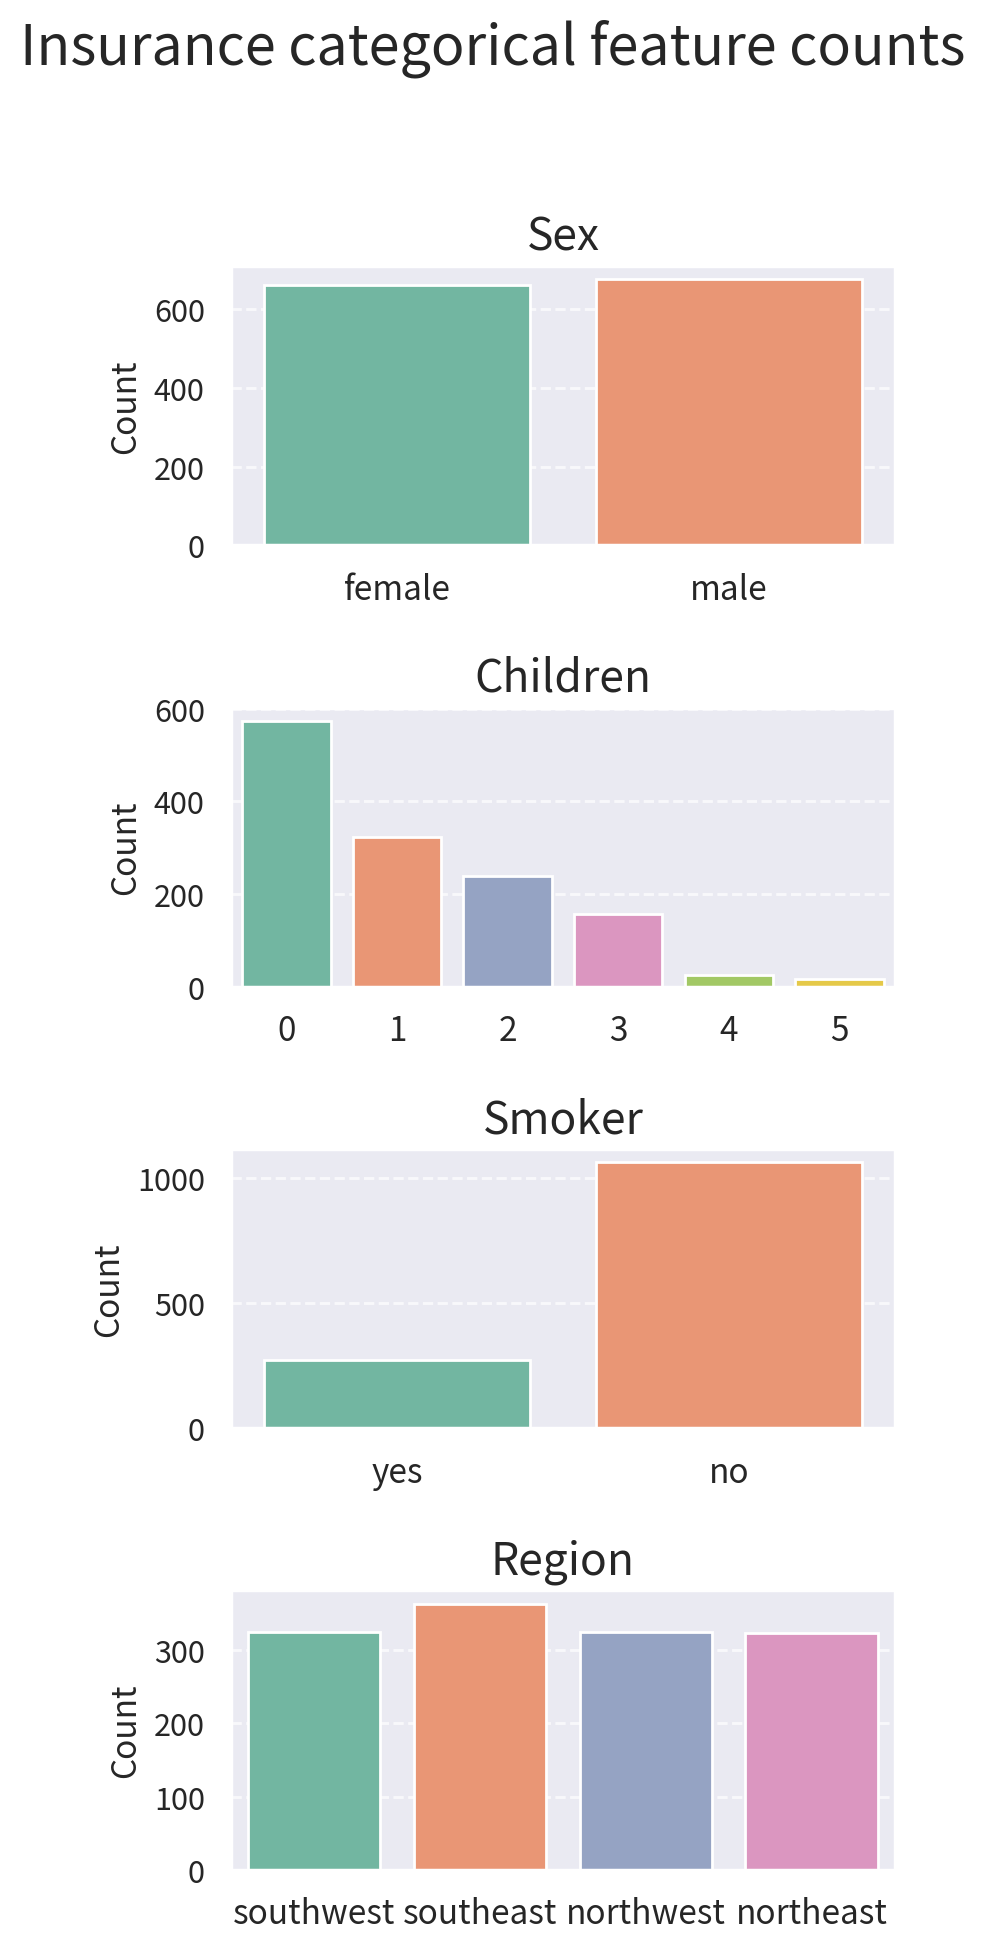

In [169]:
# 1) 그래프 초기화
width_px = 900
height_px = 2000          # ✅ 세로 크게
rows, cols = 4, 1
figsize = (width_px / 200, height_px / 200)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=200)

# 사용할 데이터프레임과 x컬럼 매핑
plot_info = [
    (sex_df, 'sex', 'Sex'),
    (children_df, 'children', 'Children'),
    (smoker_df, 'smoker', 'Smoker'),
    (region_df, 'region', 'Region')
]

# 2) barplot 그리기
for i, (df, x_col, title) in enumerate(plot_info):
    sb.barplot(
        data=df,
        x=x_col,
        y='count',
        palette='Set2',
        ax=ax[i]
    )

    # 3) 그래프 꾸미기
    ax[i].grid(axis='y', linestyle='--', alpha=0.7)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Count', fontsize=12)
    ax[i].set_title(title, fontsize=16, fontweight='bold')
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].tick_params(axis='y', labelsize=11)

# 전체 제목
fig.suptitle(
    'Insurance categorical feature counts',
    fontsize=20,
    fontweight='bold'
)

# 4) 출력
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
plt.close()


- charges, age, bmi, children  변수 시각화

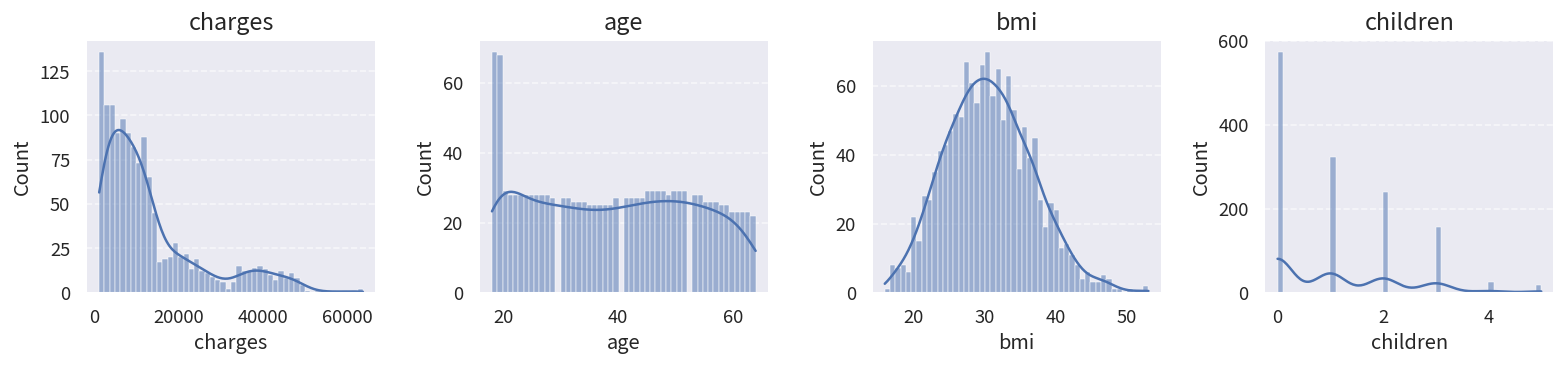

In [170]:
# 1) 그래프 초기화
width_px = 1600
height_px = 400
rows, cols = 1, 4
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

cols_list = ['charges', 'age', 'bmi', 'children']

# 2) 히스토그램 + KDE
for i, col in enumerate(cols_list):
    sb.histplot(
        data=df_plot,
        x=col,
        bins=50,
        kde=True,
        ax=ax[i]
    )
    ax[i].set_title(col, fontsize=14, fontweight='bold')
    ax[i].grid(axis='y', linestyle='--', alpha=0.6)

# 3) 출력
plt.tight_layout()
plt.show()
plt.close()


### STEP 2. 의료보험 청구 비용 시각화
1. 작업 요약
  - charges 에만 log 변환을 적용
  
2. 기대 효과
  - 강한 오른쪽 왜도를 완화하여 분포를 보다 대칭적으로 만듦
  - 극단적 고액 의료비의 영향 감소
  - 잔차의 정규성·등분산성 개선 → 회귀 적합 안정화

- charges 로그 변환 전/후 비교

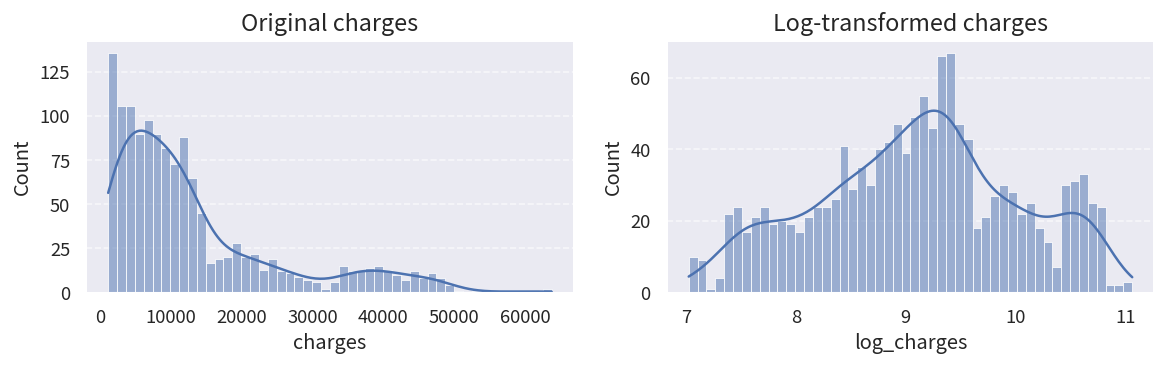

In [171]:
import numpy as np
df_log = df_plot.copy()
# 원본 유지 + 로그 변환 컬럼 생성
df_log['log_charges'] = np.log1p(df_log['charges'])

# 1) 그래프 초기화
width_px = 1200
height_px = 400
rows, cols = 1, 2
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 원본 charges
sb.histplot(
    data=df_log,
    x='charges',
    bins=50,
    kde=True,
    ax=ax[0]
)
ax[0].set_title('Original charges', fontsize=14, fontweight='bold')
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# 3) 로그 변환 charges
sb.histplot(
    data=df_log,
    x='log_charges',
    bins=50,
    kde=True,
    ax=ax[1]
)
ax[1].set_title('Log-transformed charges', fontsize=14, fontweight='bold')
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()



### STEP 3. EDA
 - 3-1 성별, 흡연 여부, 지역 의료비, bmi , 연령은 charges 결정에 결정적인 역할을 할까?
   > 흡연 여부와 연령의료비 결정에 비교적 중요한 역할을 하는 반면, 성별과 지역의 영향은 상대적으로 제한적으로 보임. BMI는 smoker 변수와 함께 보았을 때 smoker 에 따른 차이점이 확인되었음.
   
 - 3-2 그렇다면 흡연율은?
   > 

 - 3-3 그렇다면 가장 크게 작용하는 변수는? (생략)


 - 3-4 상관분석


 - 3-4-2 “어떤 변수가 의료비와 가장 가까울까?” (생략)

- age , bmi 구간 기준 추가하기

In [172]:
df_add_age_bmi_standard=df_log.copy()


In [173]:
# NCHS 기준 age 구간화
bins = [18, 24, 34, 44, 64]
labels = ['18-24', '25-34', '35-44', '45-64']

df_add_age_bmi_standard['age_group'] = pd.cut(
    df_add_age_bmi_standard['age'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)


# who 기준
bmi_bins = [0, 18.5, 25, 30, float('inf')]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']

df_add_age_bmi_standard['bmi_group'] = pd.cut(
    df_add_age_bmi_standard['bmi'],
    bins=bmi_bins,
    labels=bmi_labels,
    include_lowest=True,
    right=False
)

df_add_age_bmi_standard


,age,sex,bmi,children,smoker,region,charges,log_charges,age_group,bmi_group
0,19,female,27.900,0,yes,southwest,16884.92400,9.734236,18-24,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,7.453882,18-24,Obese
2,28,male,33.000,3,no,southeast,4449.46200,8.400763,25-34,Obese
3,33,male,22.705,0,no,northwest,21984.47061,9.998137,25-34,Normal
4,32,male,28.880,0,no,northwest,3866.85520,8.260455,25-34,Overweight
...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,9.268755,45-64,Obese
1334,18,female,31.920,0,no,northeast,2205.98080,7.699381,18-24,Obese
1335,18,female,36.850,0,no,southeast,1629.83350,7.396847,18-24,Obese
1336,21,female,25.800,0,no,southwest,2007.94500,7.605365,18-24,Overweight


#### 3-1 성별, 흡연 여부, 지역 , 자녀수 , BMI 의료비 결정에 결정적인 역할을 할까?
> 시각화로 전체적인 데이터 현황 확인

In [174]:
df_plot2 = df_add_age_bmi_standard.copy()

#### 성별에 따른 의료비 분포 비교
(1) sex × charges (박스플롯 + 바이올린 플롯)
- 성별에 따른 의료비 분포를 보면, 남성과 여성의 중앙값은 유사하며 분포가 크게 겹쳐 있다.
남성 집단에서 고액 의료비 사례가 다소 더 넓게 분포하는 경향은 관찰되지만,
박스플롯과 바이올린 플롯 모두에서 중앙값과 주요 분포 구간의 차이는 뚜렷하지 않다.
따라서 성별 자체가 의료비를 명확히 구분하는 결정적 요인이라고 보기는 어렵다.

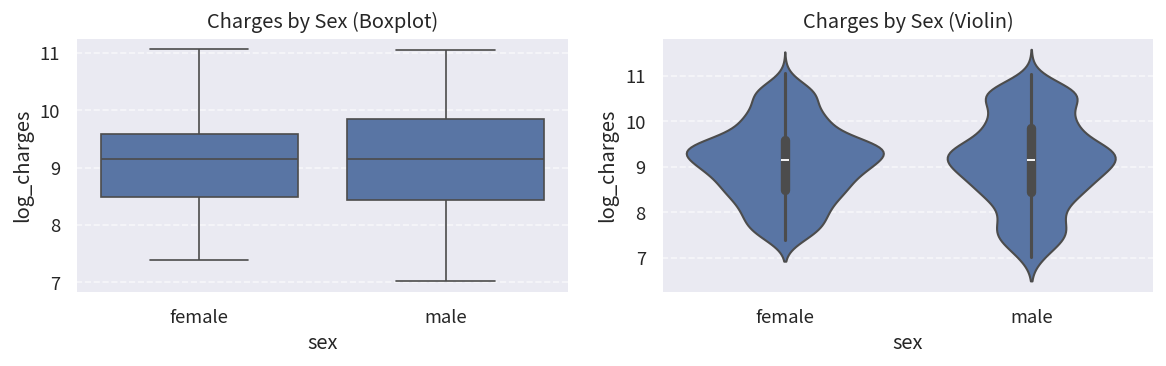

In [175]:

# 1) 그래프 초기화
width_px, height_px = 1200, 400
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)

# 박스플롯
sb.boxplot(data=df_plot2, x='sex', y='log_charges', ax=ax[0])
ax[0].set_title('Charges by Sex (Boxplot)')
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# 바이올린 플롯
sb.violinplot(data=df_plot2, x='sex', y='log_charges', ax=ax[1])
ax[1].set_title('Charges by Sex (Violin)')
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()


#### 흡연에 따른 의료비 분포 비교

(2) smoker × charges (박스플롯 + 바이올린 플롯)
  - 흡연 여부에 따른 의료비 분포를 박스플롯과 바이올린 플롯으로 시각화한 결과,
  흡연자(smoker = yes)는 비흡연자(smoker = no)에 비해 의료비의 중앙값과 분포 중심이 현저히 높게 나타났다.또한 흡연자 집단은 고액 의료비 방향으로 긴 꼬리(long-tail)를 가지며,
  두 집단의 분포는 겹침이 매우 제한적으로 시각적으로도 뚜렷한 차이를 보였다.

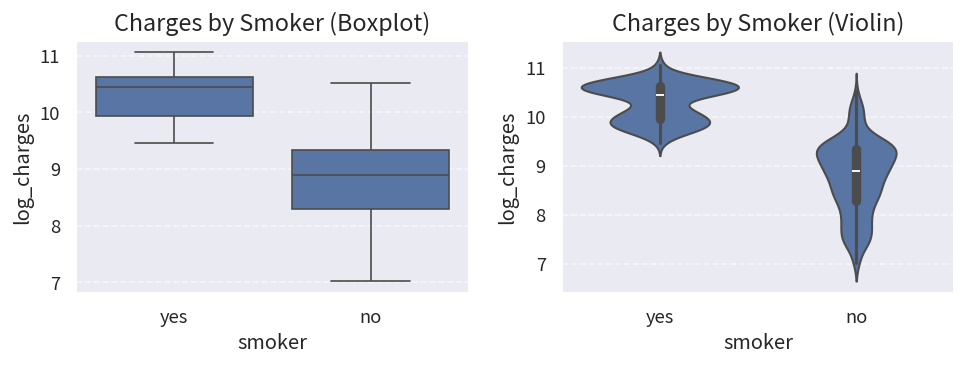

In [176]:
# 1) 그래프 초기화
width_px, height_px = 1000, 400
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)

# 2) 박스플롯
sb.boxplot(data=df_plot2, x='smoker', y='log_charges', ax=ax[0])
ax[0].set_title('Charges by Smoker (Boxplot)', fontsize=14, fontweight='bold')
ax[0].grid(axis='y', linestyle='--', alpha=0.6)


# 3) 바이올린 플롯
sb.violinplot(data=df_plot2, x='smoker', y='log_charges', ax=ax[1])
ax[1].set_title('Charges by Smoker (Violin)', fontsize=14, fontweight='bold')
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()


#### 지역에 따른 의료비 분포 비교
(3) region × charges (박스플롯 + 바이올린 플롯)
- 지역별 의료비 분포를 비교한 결과,
네 지역의 중앙값은 서로 큰 차이를 보이지 않으며,
분포 또한 상당 부분 겹쳐 있다.
다만 southeast 지역에서 고액 의료비 사례가
상대적으로 눈에 띄게 관찰되지만,
이를 근거로 지역 간 의료비 차이가 뚜렷하다고 단정하기는 어렵다.

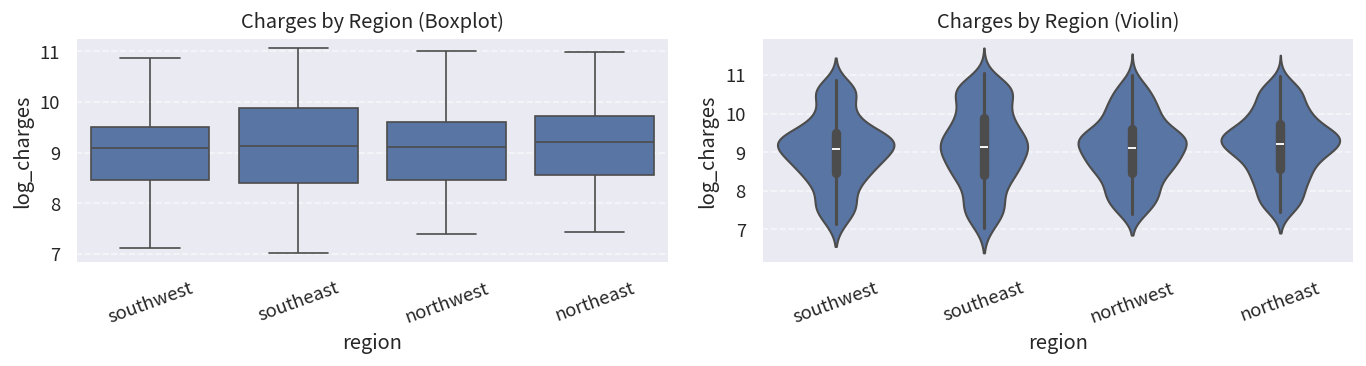

In [177]:
# 1) 그래프 초기화
width_px, height_px = 1400, 400
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)

# 박스플롯
sb.boxplot(data=df_plot2, x='region', y='log_charges', ax=ax[0])
ax[0].set_title('Charges by Region (Boxplot)')
ax[0].tick_params(axis='x', rotation=20)
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# 바이올린 플롯
sb.violinplot(data=df_plot2, x='region', y='log_charges', ax=ax[1])
ax[1].set_title('Charges by Region (Violin)')
ax[1].tick_params(axis='x', rotation=20)
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()


#### 연령대에 따른 의료비 분포 비교
(4) age_group × charges (박스플롯 + 바이올린 플롯)
- 연령대가 높아질수록 log_charges가 증가하는 뚜렷한 경향이 보임 
18–24 < 25–34 < 35–44 < 45–64

즉, 나이가 많을수록 의료비가 전반적으로 높아지며
연령은 의료비에 양(+)의 관계를 갖는 중요한 변수로 보임

특히 45–64세 집단에서 가장 높은 의료비 수준이 관찰되었다.

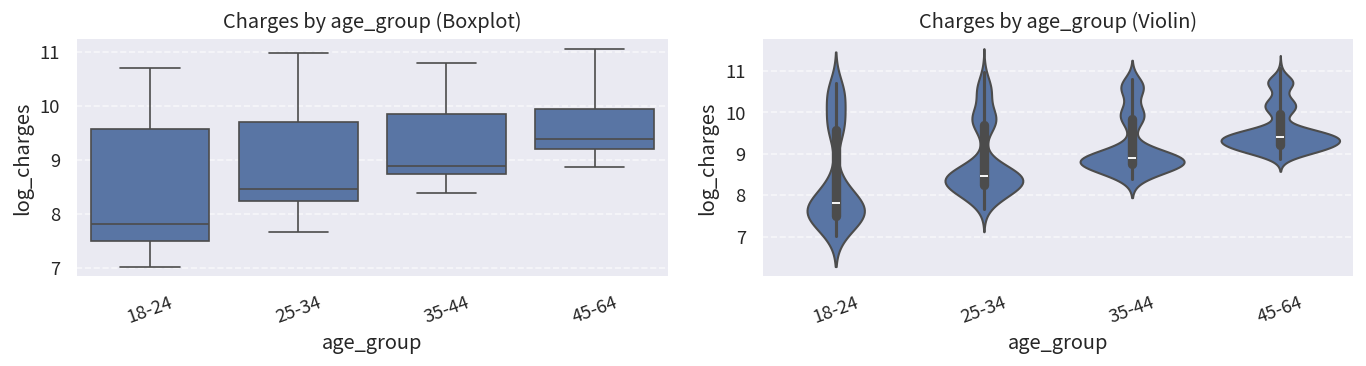

In [178]:
# 1) 그래프 초기화
width_px, height_px = 1400, 400
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)

# 박스플롯
sb.boxplot(data=df_plot2, x='age_group', y='log_charges', ax=ax[0])
ax[0].set_title('Charges by age_group (Boxplot)')
ax[0].tick_params(axis='x', rotation=20)
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# 바이올린 플롯
sb.violinplot(data=df_plot2, x='age_group', y='log_charges', ax=ax[1])
ax[1].set_title('Charges by age_group (Violin)')
ax[1].tick_params(axis='x', rotation=20)
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()


#### 자녀수에 따른 의료비 분포 비교
(5) children × log_charges 산점도 + 회귀선
- 자녀 수에 따른 로그 의료비 분포를 살펴본 결과,
자녀 수가 증가할수록 의료비가 완만하게 증가하는 경향이 관찰된다.

회귀선의 기울기는 양(+)의 값을 보이지만,
각 자녀 수 구간 내에서 의료비 분포의 산포가 크게 나타나며
값들이 상당 부분 겹쳐 있다.

특히 자녀 수가 적은 경우에도 고액 의료비 사례가 다수 존재하고,
자녀 수가 많은 경우에도 상대적으로 낮은 의료비 관측치가 확인된다.

따라서 자녀 수와 의료비 간에 약한 양의 관계는 존재하나,
자녀 수만으로 의료비 수준을 설명하기에는 한계가 있으며
다른 요인들의 영향이 함께 고려될 필요가 있다.

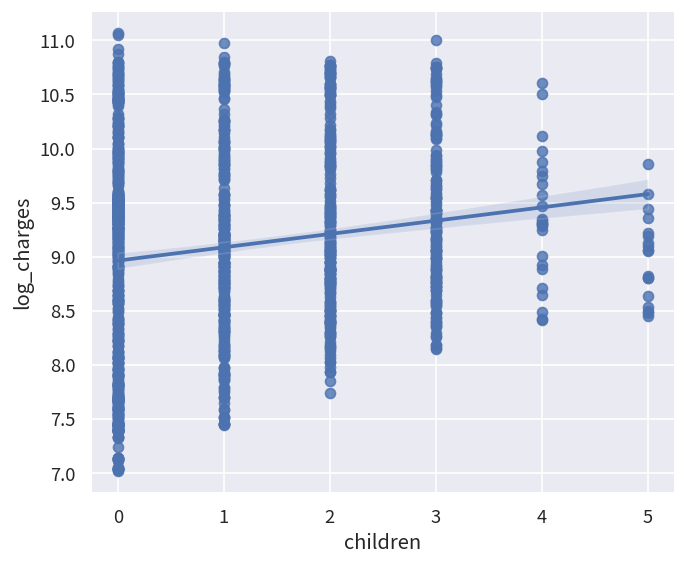

In [179]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

#아래의 초기화 부분은 생략된다 
#fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LM plot 그리기
#그래프를 꾸미기 위해서는 LM PLOT () 메서드로부터 리턴되는 객체 g 를 활용해야 한다

g=sb.lmplot(data=df_plot2 , x='children', y='log_charges')

g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figwidth(figsize[1])

#두개의 그래프가 생성되면 각 그래프에 대해 그리드 설정은 별도로 필요하다
for ax in g.axes.flatten():
  ax.grid(True)




# 3) 출력
plt.tight_layout()                     # 여백 제거
plt.savefig("plot.png", dpi=my_dpi * 2)
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


#### BMI 에 따른 의료비 분포 비교
(6) bmi × log_charges 산점도 + 회귀선
- (전체 데이터) BMI를 연속형 변수로 분석할 경우
BMI 증가에 따른 의료비의 점진적인 변화는 확인할 수 있었으나,
의료비 수준이 어느 구간에서 구조적으로 변화하는지에 대한 해석에는 한계가 있었다.

이에 BMI를 WHO 기준에 따라 범주형 변수로 구분하여 분석한 결과,
정상(Normal) 및 과체중(Overweight) 구간에서는
의료비 분포가 상당 부분 중첩되는 반면,
비만(Obese) 구간에서 의료비의 중앙값과 상위 분포가 뚜렷하게 상승하는 양상이 관찰되었다.

이는 BMI가 의료비에 선형적으로 작용하기보다는,
비만 구간에 진입하면서 의료비 수준을 구조적으로 변화시키는 변수임을 시사한다.


한편 BMI가 의료비에 일정 부분 영향을 미치지만,
BMI 단독 변수로 의료비 수준을 충분히 설명하기는 어렵다고 판단되어 
성별, smoker 을 기준으로 추가적인 시각화를 진행하였다 

- (성별)
성별에 따라 BMI와 의료비의 관계를 비교한 결과,
남성과 여성 모두에서 BMI 증가에 따른 의료비 상승 경향이 나타난다.

두 집단의 회귀선 기울기는 유사하며,
의료비 분포 또한 상당 부분 겹쳐 있어
성별에 따른 뚜렷한 의료비 수준 차이는 제한적으로 보인다.

따라서 성별은 의료비에 일정한 영향을 줄 수 있으나,
BMI와 의료비 간 관계를 구조적으로 변화시키는 요인으로 보기는 어렵다.


- (흡연)
흡연 여부에 따라 BMI와 의료비 간의 관계를 비교한 결과,
흡연자 집단에서 전반적으로 의료비 수준이 비흡연자보다 현저히 높게 나타난다.

특히 흡연자의 경우 BMI 증가에 따라 의료비가 가파르게 증가하는 경향이 관찰되며,
회귀선의 기울기 또한 비흡연자보다 크게 나타난다.

반면 비흡연자 집단에서는 BMI 증가에 따른 의료비 상승 폭이 상대적으로 완만하며,
전체 의료비 수준 역시 낮게 분포한다.

동일한 BMI 구간에서도 흡연자의 의료비 분포가 비흡연자보다 상단에 위치하여,
흡연 여부가 BMI보다 의료비에 더 강한 영향을 미치는 주요 요인임을 시사한다.

이는 BMI와 의료비 간의 관계가 흡연 여부에 따라 상호작용 효과(interaction)를 가질 가능성을 보여준다.

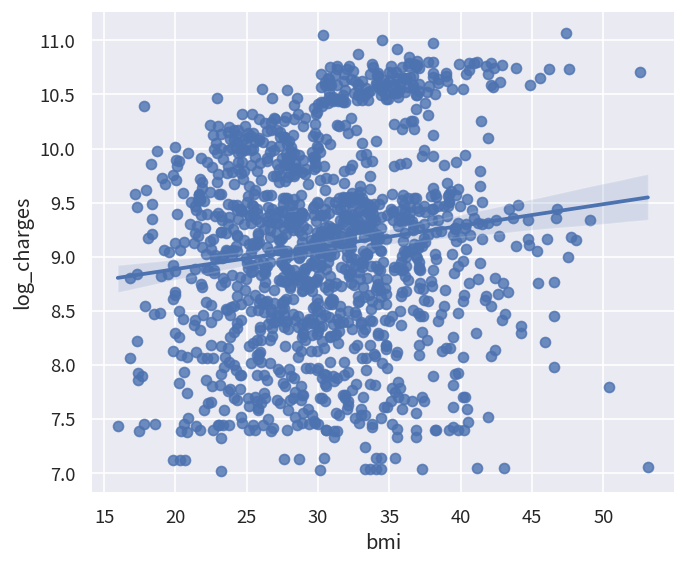

In [180]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

#아래의 초기화 부분은 생략된다 
#fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LM plot 그리기
#그래프를 꾸미기 위해서는 LM PLOT () 메서드로부터 리턴되는 객체 g 를 활용해야 한다

g=sb.lmplot(data=df_plot2 , x='bmi', y='log_charges')

g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figwidth(figsize[1])

#두개의 그래프가 생성되면 각 그래프에 대해 그리드 설정은 별도로 필요하다
for ax in g.axes.flatten():
  ax.grid(True)




# 3) 출력
plt.tight_layout()                     # 여백 제거
plt.savefig("plot.png", dpi=my_dpi * 2)
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


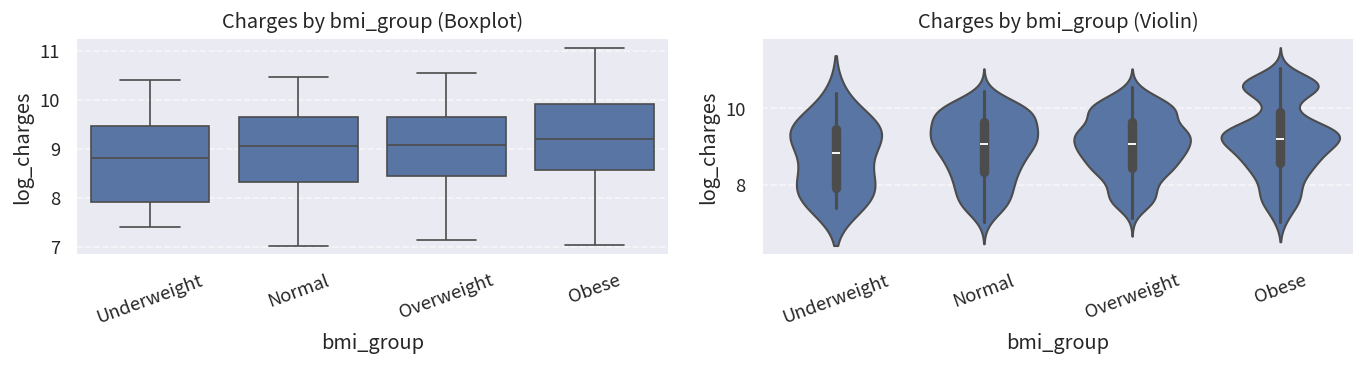

In [181]:
# 1) 그래프 초기화
width_px, height_px = 1400, 400
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)

# 박스플롯
sb.boxplot(data=df_plot2, x='bmi_group', y='log_charges', ax=ax[0])
ax[0].set_title('Charges by bmi_group (Boxplot)')
ax[0].tick_params(axis='x', rotation=20)
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# 바이올린 플롯
sb.violinplot(data=df_plot2, x='bmi_group', y='log_charges', ax=ax[1])
ax[1].set_title('Charges by bmi_group (Violin)')
ax[1].tick_params(axis='x', rotation=20)
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()


- sex 에 따른 bmi 와 log_charges 의 관계

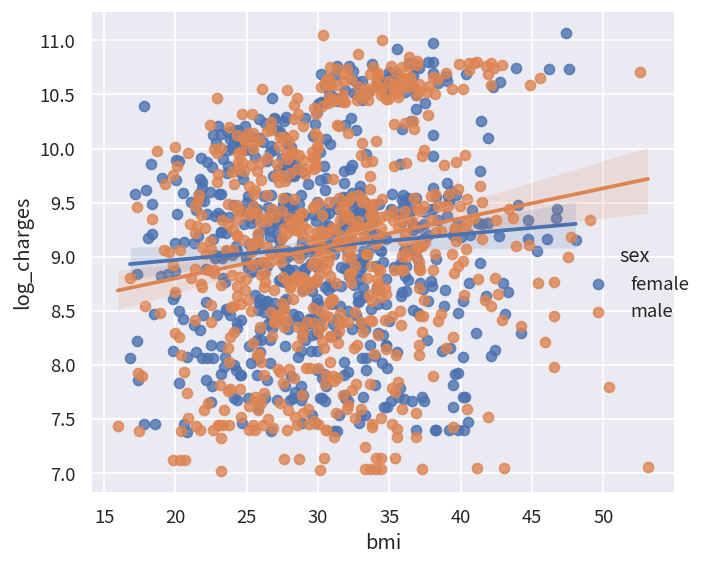

In [182]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

#아래의 초기화 부분은 생략된다 
#fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LM plot 그리기
#그래프를 꾸미기 위해서는 LM PLOT () 메서드로부터 리턴되는 객체 g 를 활용해야 한다

g=sb.lmplot(data=df_plot2 , x='bmi', y='log_charges',hue = 'sex' )

g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figwidth(figsize[1])

#두개의 그래프가 생성되면 각 그래프에 대해 그리드 설정은 별도로 필요하다
for ax in g.axes.flatten():
  ax.grid(True)




# 3) 출력
plt.tight_layout()                     # 여백 제거
plt.savefig("plot.png", dpi=my_dpi * 2)
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


- smoker 에 따른 bmi 와 log_charges 의 관계

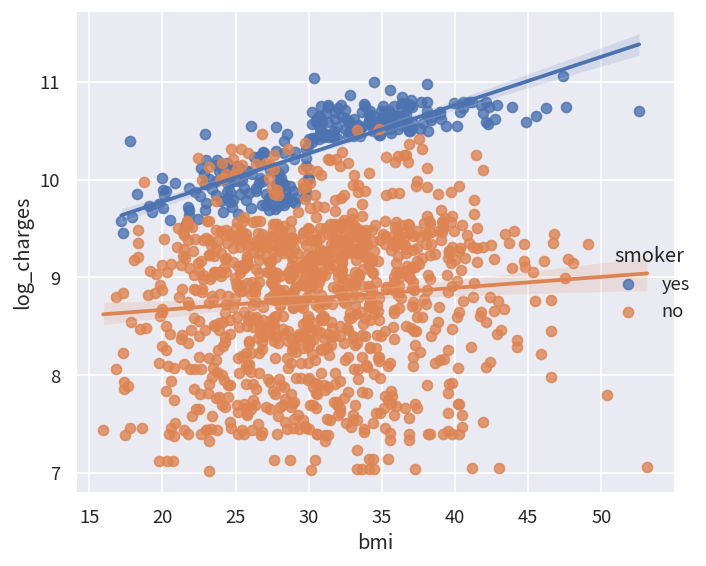

In [183]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

#아래의 초기화 부분은 생략된다 
#fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LM plot 그리기
#그래프를 꾸미기 위해서는 LM PLOT () 메서드로부터 리턴되는 객체 g 를 활용해야 한다

g=sb.lmplot(data=df_plot2 , x='bmi', y='log_charges',hue = 'smoker' )

g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figwidth(figsize[1])

#두개의 그래프가 생성되면 각 그래프에 대해 그리드 설정은 별도로 필요하다
for ax in g.axes.flatten():
  ax.grid(True)




# 3) 출력
plt.tight_layout()                     # 여백 제거
plt.savefig("plot.png", dpi=my_dpi * 2)
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


> 각 변수들에 대해 시각화를 진행하여 분포를 확인하였고, 흡연 , 연령대 , bmi 구간 변수에 대해 추가적인 통계적 검증 진행

#### 흡연 여부에 따른 평균 차이의 유의미성 확인 

1. 추가 분석 배경
  - 흡연 여부에 따른 의료비 분포를 박스플롯과 바이올린 플롯으로 시각화한 결과,
  흡연자(smoker = yes)는 비흡연자(smoker = no)에 비해 의료비의 중앙값과 분포 중심이 현저히 높게 나타났다.또한 흡연자 집단은 **고액 의료비 방향으로 긴 꼬리(long-tail)**를 가지며,
  두 집단의 분포는 겹침이 매우 제한적으로 시각적으로도 뚜렷한 차이를 보였다.


2. 정규성/등분산성 검정 
 - 정규성 검정 결과, 흡연자와 비흡연자 두 집단 모두 정규성 가정을 충족하지 않았으며,
  Levene 검정을 통해 등분산성 가정 역시 충족되지 않음을 확인하였다.
  이에 따라 등분산을 가정하지 않는 Welch’s t-test를 사용하여
  두 집단의 평균 의료비 차이를 검정하였다.

3.  Welch's t test 
  - Welch’s t-test 결과는 다음과 같다
  t-statistic = −32.75
  p-value ≈ 0 (p < 0.001)
  p-value가 유의수준 0.05보다 매우 작으므로 귀무가설을 기각한다.
  즉, 비흡연자의 평균 의료비는 흡연자보다 통계적으로 유의하게 작다,
  다시 말해 흡연 여부에 따라 의료비 평균에는 매우 유의한 차이가 존재한다고 할 수 있다.


  4. 효과 크기를 의료 정책 관점에서 서술
  - 흡연자는 비흡연자에 비해 평균적으로 훨씬 높은 의료비를 발생시키므로,
  흡연은 개인의 건강 문제를 넘어 의료 시스템 전체의 비용 부담을 증가시키는 요인으로 해석할 수 있다.
  이러한 결과는 금연 정책, 예방 중심의 공공 보건 전략,
  그리고 흡연 관련 건강 관리 프로그램의 필요성을 뒷받침하는 근거로 활용될 수 있다.

- [1] t test 진행을 위한 데이터 프레임 준비

In [184]:
# 흡연자 / 비흡연자 charges 추출
charges_yes = df_plot2.loc[df_plot2['smoker'] == 'yes', 'log_charges'].reset_index(drop=True)
charges_no  = df_plot2.loc[df_plot2['smoker'] == 'no',  'log_charges'].reset_index(drop=True)

# 두 집단을 나란히 DataFrame으로 결합
ttest_df = pd.DataFrame({
    'smoker_yes': charges_yes,
    'smoker_no': charges_no
})

ttest_df.tail()


,smoker_yes,smoker_no
1059,NaN,9.342481
1060,NaN,9.268755
1061,NaN,7.699381
1062,NaN,7.396847
1063,NaN,7.605365


- [2] 신뢰구간 확인
두 그룹의 데이터 분포와 신뢰구간을 확인한다

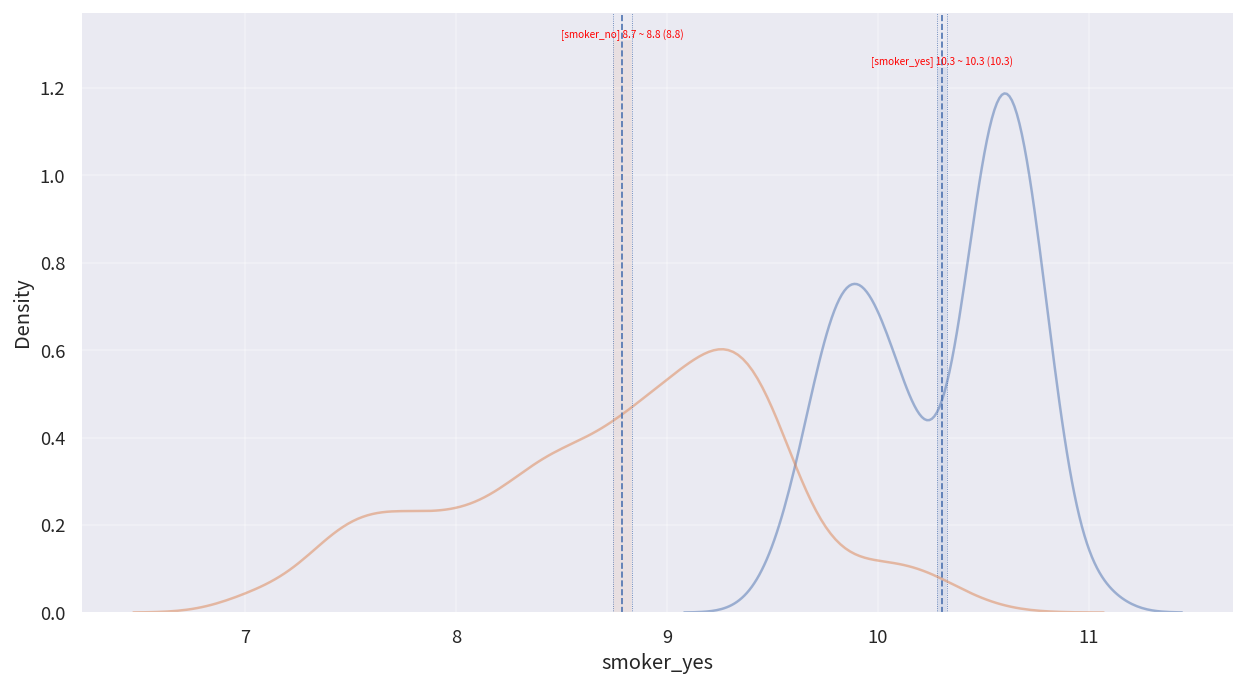

In [185]:
data = ttest_df[['smoker_yes','smoker_no']]                # 확인할 데이터

# 1) 그래프 초기화
width_px  = 1280                      # 그래프 가로 크기
height_px = 720                       # 그래프 세로 크기
rows = 1                              # 그래프 행 수
cols = 1                              # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    # KDE Plot 그리기
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 신뢰구간
    max = data[c].max()               # 최대값
    clevel = 0.95                     # 신뢰수준
    dof = len(data[c]) - 1            # 자유도
    sp_mean = data[c].mean()          # 표본평균
    sp_std = data[c].std(ddof=1)      # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c]))  # 표본표준오차

    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s=f"[{c}] {cmin:.1f} ~ {cmax:.1f} ({sp_mean:.1f})",
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"})

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)

# 4) 출력
plt.tight_layout()      # 여백 제거
plt.show()              # 그래프 화면 출력
plt.close()             # 그래프 작업 종료


흡연자(smoker=yes)와 비흡연자(smoker=no)의 의료비에 대한 커널 밀도 함수(KDE)를 비교한 결과,
두 집단의 분포 중심과 형태가 뚜렷하게 구분됨을 확인할 수 있다.
흡연자 집단은 의료비 분포의 중심이 더 높은 값에 위치하며,
고액 의료비 방향으로 긴 꼬리를 가지는 반면,
비흡연자 집단은 상대적으로 낮은 의료비 구간에 분포가 집중되어 있다.
두 집단의 분포 겹침이 제한적이므로,
흡연 여부에 따른 의료비 차이는 시각적으로도 매우 뚜렷하게 나타난다.

- [3] 가설 검정의 가정 확인

In [186]:
import numpy as np
import pandas as pd
from scipy.stats import normaltest, bartlett, levene

data = ttest_df[['smoker_yes','smoker_no']]

normal_dist = True
report = []

series_dict = {}  # dropna된 시리즈 저장

for c in data.columns:
    srs = data[c].dropna()
    series_dict[c] = srs

    # normaltest는 표본이 너무 적으면 의미 없을 수 있어요(보통 n>=8 권장)
    s, p = normaltest(srs)

    normalize = p > 0.05
    report.append({"field": c, "statistic": s, "p-value": p, "result": normalize})
    normal_dist = normal_dist and normalize

# 등분산 검정 (두 집단)
x = series_dict['smoker_yes']
y = series_dict['smoker_no']

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(x, y)
else:
    n = "Levene"
    s, p = levene(x, y, center='median')

report.append({"field": n, "statistic": s, "p-value": p, "result": p > 0.05})

report_df = pd.DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
smoker_yes,182.441412,2.417412e-40,False
smoker_no,37.435884,7.428501e-09,False
Levene,89.473006,1.347330e-20,False


> 정규성과 등분산성을 충족하지 않아 mannwhitneyu 비모수 검정을 진행해야한다

| 구분        | 기호      | 내용                                 |
| --------- | ------- | ---------------------------------- |
| 그룹 1 평균   | μ₁      | 흡연자(smoker = yes)의 의료비(charges) 평균 |
| 그룹 2 평균   | μ₂      | 비흡연자(smoker = no)의 의료비(charges) 평균 |
| 귀무가설 (H₀) | μ₁ = μ₂ | 흡연자와 비흡연자의 의료비 평균에는 차이가 없다         |
| 대립가설 (H₁) | μ₁ ≠ μ₂ | 흡연자와 비흡연자의 의료비 평균에는 차이가 있다         |



In [187]:
from scipy import stats

# 두 그룹 데이터 (NaN 제거)
group1 = ttest_df['smoker_yes'].dropna()   # 흡연자
group2 = ttest_df['smoker_no'].dropna()    # 비흡연자

# Welch's t-test (equal_var=False)
s, p = stats.mannwhitneyu(
    group1,
    group2,
    alternative='two-sided',
)

print(
    "statistic: {0:.3f}, p-value: {1:.3e}, {2}가설 채택"
    .format(s, p, "대립" if p <= 0.05 else "귀무")
)


statistic: 284133.000, p-value: 5.270e-130, 대립가설 채택


> Mann-Whitney U Test 결과, 흡연자와 비흡연자의 평균 의료비 차이는 통계적으로 매우 유의하였다
(검정통계량 = 284133.000, p < 0.00... ).
유의확률이 유의수준 0.05보다 작기때문에 귀무가설을 기각하고, 흡연 여부에 따라 의료비 평균에 차이가 있다는 대립가설을 채택한다.

- 비흡연자의 의료비가 흡연자의 의료비보다 작은지 검정
(= 흡연자가 더 비싼지 검정)

| 구분        | 수식             | 내용                         |
| --------- | -------------- | -------------------------- |
| 귀무가설 (H₀) | μ(no) ≥ μ(yes) | 비흡연자의 평균 의료비는 흡연자보다 작지 않다  |
| 대립가설 (H₁) | μ(no) < μ(yes) | **비흡연자의 평균 의료비는 흡연자보다 작다** |


In [188]:
from scipy.stats import ttest_ind

non_smoker = ttest_df['smoker_no'].dropna()
smoker = ttest_df['smoker_yes'].dropna()

s, p = stats.mannwhitneyu(
    non_smoker,
    smoker,
    alternative='less'
)

print(
    "statistic: {0:.3f}, p-value: {1:.3e}, {2}가설 채택"
    .format(s, p, "대립" if p <= 0.05 else "귀무")
)


statistic: 7403.000, p-value: 2.635e-130, 대립가설 채택


- Mann-Whitney U Test 결과, 두 집단의 평균 의료비 차이는 통계적으로 유의하였다
(검정통계량 = 7403.000 , p-value = 0.00...).
이에 따라 비흡연자의 평균 의료비는 흡연자보다 유의하게 작다고 판단된다.

#### 나이 구간 에 따른 평균 차이의 유의미성 확인 
- age를 여러 구간으로 나누어(예: 18~30, 31~50, 51+) 각 연령대별 charges 분포를 시각화한다.
  - 연령대를 NCHS(미국 국립보건통계센터) Distribution #22 기준에 따라
  18–24세, 25–34세, 35–44세, 45–64세의 네 개 구간으로 구분하여
  각 연령대별 의료비(charges) 분포를 시각화하였다.

  그 결과, 연령이 증가할수록 의료비의 중앙값(median) 이 점진적으로 상승하는 경향이 관찰되었으며,동시에 분포의 상단(고액 의료비 영역) 또한 점차 확장되는 모습을 보였다.특히 45–64세 연령대에서는 분포의 꼬리가 길어지며,
  고액 의료비 사례가 다른 연령대에 비해 상대적으로 많이 나타났다.

  이는 연령 증가에 따라 만성질환 유병률과 의료 이용 빈도가 함께 증가할 가능성을 시사한다.

- 분산분석(ANOVA)으로 전체 차이를 확인하고, 사후검정으로 어느 연령대 사이에서 차이가 나는지 정리한다.
  - Welch ANOVA 결과, 연령대에 따라 평균 의료비는 통계적으로 유의미한 차이를 보였다
  (F = 36.77, p < 0.001).
  이는 연령대가 의료비 변동을 설명하는 중요한 요인임을 의미하며,
  단순한 우연이 아닌 구조적인 차이가 존재함을 시사한다.


- 사후검정은 Tukey HSD 또는 Games-Howell(등분산 위반 시)을 사용하고, “의료비 연령 서열표” 형태로 요약하세요.

| 연령대       | 평균 의료비 수준 | 해석                   |
| --------- | --------- | -------------------- |
| **18–24** | 가장 낮음     | 의료 이용 및 비용 부담이 가장 적음 |
| **25–34** | 낮음        | 의료비 증가 시작 단계         |
| **35–44** | 중간        | 의료 이용 및 비용이 본격적으로 증가 |
| **45–64** | 가장 높음     | 고액 의료비 위험이 가장 큼      |

  연령 서열:
  18–24 < 25–34 < 35–44 < 45–64

** 분석 대상의 연령 구간은 NCHS(미국 국립보건통계센터)의 Distribution #22 분류 체계에 따라 18-24세, 25-34세, 35-44세, 45-64세의 4개 그룹으로 층화(stratified) 하였다 (해당 기준은 미국 보건·의료 통계 및 보험 관련 연구에서
연령에 따른 건강 상태와 의료 이용 패턴을 비교하기 위해
널리 활용되는 생애 단계 기반 분류이다.)

[1] 데이터 분포 확인 

In [198]:
# df_age: age, age_group(18-24 / 25-34 / 35-44 / 45-64) 포함

age_18_24 = df_plot2.loc[df_plot2['age_group'] == '18-24', 'log_charges']
age_25_34 = df_plot2.loc[df_plot2['age_group'] == '25-34', 'log_charges']
age_35_44 = df_plot2.loc[df_plot2['age_group'] == '35-44', 'log_charges']
age_45_64 = df_plot2.loc[df_plot2['age_group'] == '45-64', 'log_charges']

data = pd.DataFrame({
    '18-24': age_18_24,
    '25-34': age_25_34,
    '35-44': age_35_44,
    '45-64': age_45_64
})


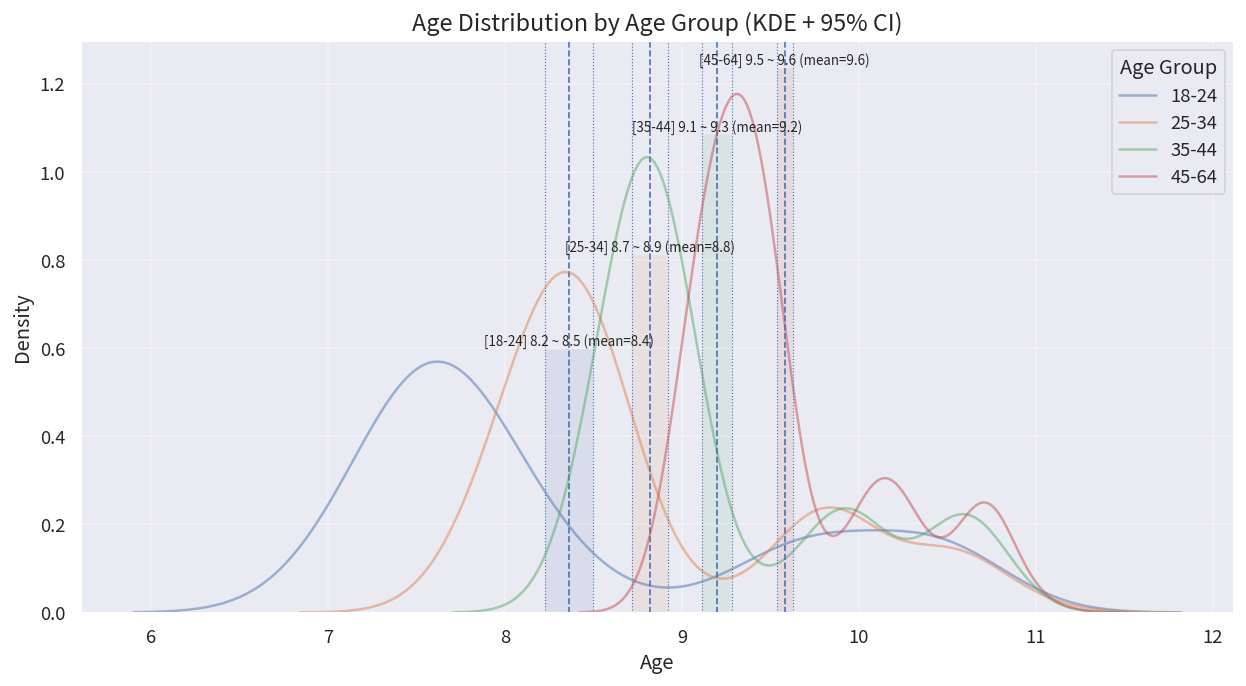

In [199]:
from math import sqrt
from scipy.stats import t

# 1) 그래프 초기화
width_px  = 1280
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    series = data[c].dropna()   # NaN 제거

    # KDE Plot
    sb.kdeplot(x=series, fill=False, alpha=0.5, label=c)

    # 신뢰구간 계산
    clevel = 0.95
    dof = len(series) - 1
    sp_mean = series.mean()
    sp_std = series.std(ddof=1)
    sp_std_error = sp_std / sqrt(len(series))

    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    # 시각화
    ax.axvline(cmin, linestyle=':', linewidth=0.7)
    ax.axvline(cmax, linestyle=':', linewidth=0.7)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)

    ax.text(
        x=(cmax + cmin) / 2,
        y=ymax,
        s=f"[{c}] {cmin:.1f} ~ {cmax:.1f} (mean={sp_mean:.1f})",
        ha='center',
        va='bottom',
        fontsize=8
    )

# 3) 그래프 꾸미기
ax.set_title('Age Distribution by Age Group (KDE + 95% CI)', fontsize=14, fontweight='bold')
ax.set_xlabel('Age')
ax.grid(True, alpha=0.3)
ax.legend(title='Age Group')

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


- 정규성 검정

In [200]:

data = pd.DataFrame({
    '18-24': df_plot2.loc[df_plot2['age_group'] == '18-24', 'log_charges'],
    '25-34': df_plot2.loc[df_plot2['age_group'] == '25-34', 'log_charges'],
    '35-44': df_plot2.loc[df_plot2['age_group'] == '35-44', 'log_charges'],
    '45-64': df_plot2.loc[df_plot2['age_group'] == '45-64', 'log_charges']
})

In [201]:
from scipy.stats import normaltest, bartlett, levene
from pandas import DataFrame

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    series = data[c].dropna()   # ⭐ 반드시 NaN 제거

    s, p = normaltest(series)

    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })

    normal_dist = normal_dist and normalize


# 변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns) > 1:
    if normal_dist:
        n = "Bartlett"               # 정규성 충족 시
        s, p = bartlett(*[data[c].dropna() for c in data.columns])
    else:
        n = "Levene"                 # 정규성 미충족 시
        s, p = levene(*[data[c].dropna() for c in data.columns], center="median")

    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index("field")
report_df


,statistic,p-value,result
field,,,
18-24,59.703719,1.085181e-13,False
25-34,35.841525,1.648586e-08,False
35-44,38.804928,3.746423e-09,False
45-64,73.523609,1.082808e-16,False
Levene,37.773842,1.983729e-23,False


> 연령대별 의료비에 대해 정규성 검정 결과는 충족되지 않았고,
Levene 검정 결과 등분산성 가정도 충족되지 않았다.
표본 수가 충분히 크므로 분산분석을 수행할 수 있으며,
분포의 왜도를 고려하여 Welch ANOVA를 사용하였다.

🔹 가설 설정
| 구분            | 내용                                             |
| ------------- | ---------------------------------------------- |
| **귀무가설 (H₀)** | 연령대별(18–24, 25–34, 35–44, 45–64) 평균 의료비는 모두 같다 |
| **대립가설 (H₁)** | 적어도 한 연령대의 평균 의료비는 다른 연령대와 다르다                 |


🔹 결과 해석
| 항목          | 값            | 의미                          |
| ----------- | ------------ | --------------------------- |
| **Source**  | age_group    | 비교 요인: 연령대                  |
| **ddof1**   | 3            | 집단 간 자유도 (연령대 수 − 1)        |
| **ddof2**   | 약 836        | 집단 내 자유도 (Welch 방식, 비정수 허용) |
| **F**       | 55.16        | 연령대 간 평균 의료비 차이가 큼          |
| **p-value** | 3.16 × 10⁻²³ | 매우 작음 → 귀무가설 기각             |
| **np²**     | 0.076        | 중간 수준의 효과 크기                |


In [202]:
import pingouin as pg

# 1️⃣ ANOVA 전용 데이터프레임 생성
df_age_anova = df_plot2[['age_group', 'log_charges']].dropna().copy()
df_age_anova['age_group'] = df_age_anova['age_group'].astype('category')

# 2️⃣ Welch ANOVA 수행
anova_result = pg.welch_anova(
    data=df_age_anova,
    dv='log_charges',
    between='age_group'
)

# 3️⃣ 결과 추출
s = anova_result['F'].iloc[0]
p = anova_result['p-unc'].iloc[0]

# 4️⃣ 결과 출력
print(
    "statistic: {0:.3f}, p-value: {1:.3e}, {2}가설 채택"
    .format(s, p, "대립" if p <= 0.05 else "귀무")
)

anova_result


statistic: 140.624, p-value: 4.121e-68, 대립가설 채택


,Source,ddof1,ddof2,F,p-unc,np2
0,age_group,3,566.96767,140.623684,4.120545e-68,0.263225


결론 :log(charges)를 기준으로 보았을 때, 연령대에 따라 평균 의료비는 통계적으로 유의미하게 달라지며, 연령대는 의료비를 설명하는 중요한 요인이다.

| 항목         |                               값 | 해석                                     |
| ---------- | ------------------------------: | -------------------------------------- |
| **가설 검정**  | p-value = 4.12 × 10⁻⁶⁸ (< 0.05) | 귀무가설(H₀)을 기각하고 대립가설(H₁)을 채택            |
| **통계적 의미** |                      F = 140.62 | 연령대 간 평균 log(의료비) 차이가 매우 큼             |
| **효과 크기**  |                     np² = 0.263 | 연령대는 log(의료비)에 **큰(large) 수준의 영향**을 미침 |


Welch ANOVA 결과, 연령대(age_group)에 따라 평균 log(charges) 는 통계적으로 유의미한 차이를 보였다(F = 140.62, p < 0.001).
또한 효과 크기(np² = 0.263)는 큰 수준으로, 연령대는 의료비 변동을 설명하는 핵심 요인임을 시사한다.


- 사후검정
- ANOVA의 결과를 통해 두 집단의 평균에 통계적으로 유의미한 차이가 발견되었을 때, 구체적으로 어떤 수준(들)에서 평균 차이가 나는지에 대한 검증 결과를 확인해야 할 경우 사후검정을 수행해야 한다.

| 구분              | Tukey HSD                                               | Bonferroni                                      | Games–Howell                                          |
|------------------|----------------------------------------------------------|--------------------------------------------------|--------------------------------------------------------|
| 기본 목적        | 등분산 가정에서 모든 그룹 쌍의 평균 차이 비교            | 다중 비교에서 1종 오류 증가를 제어하기 위한 p값 보정 | 등분산성 위반 시 안전하게 평균 차이 비교               |
| 사용 상황        | ✔ 집단 분산이 같을 때<br>✔ 표본 크기가 비슷할 때        | ✔ 어떤 경우도 적용 가능하나 보수적                | ✔ 분산이 서로 다를 때<br>✔ 표본 크기가 다를 때        |
| 표본 크기 동일 조건 | 전체에 포함되면 이상적                                  | 불필요                                           | 불필요                                                 |
| 주요 장점        | 그룹 간 차이를 가장 잘 찾아냄(파워 좋음)                 | 단순한 방식, 모든 비교에 적용 가능               | 등분산성 위반 시 최적, 강건함(robust)                  |
| 주요 단점        | 등분산성 깨지면 부적절                                   | 지나치게 보수적 → 실제 차이도 못 찾을 수 있음     | 계산이 조금 복잡, 일부 패키지에서만 제공               |
| statsmodels 지원 | ✔ 지원                                                   | ✔ 지원                                           | ❌ 지원 안함                                           |

----------------------------------------------------------------

| 항목                | 내용                                                                 |
|---------------------|----------------------------------------------------------------------|
| pingouin 지원       | ✔ `pairwise_tukey()`<br>✔ `pairwise_tests(padjust='bonf')`<br>✔ `pairwise_gameshowell()` |
| 추천 사용 시나리오 | - Tukey: 수업·연구에서 전형적인 ANOVA 후 사후검정<br>- Bonferroni: 비교 집단이 많고 기초적인 보정이 필요할 때<br>- Games–Howell: 도시/교육/사회과학 분야 등 실제 데이터에서 등분산성 자주 깨질 때 |




#### [2] 사후검정의 종류
| 종류                 | 사용 조건                         |
|----------------------|------------------------------------|
| **투키 HSD**         | 등분산이고 샘플 수가 동일한 경우   |
| **본페로니 교정, 피셔의 LSD, 세피의 방법** | 등분산이고 샘플 수가 다른 경우 |
| **Games–Howell**     | 등분산이 아닌 경우                |



- Welch ANOVA 결과 연령대별 평균 의료비 차이가 유의하게 나타나 사후검정을 수행하였다.
- Levene 은 통과하였지만, 분포 자체에 왜도와 표본수 차이가 존재하는 것을 감안하여 .등분산 가정을 필요로 하지 않는 Games–Howell 검정을 사용하였다. 

#### Games-Howel 검정

**Games–Howell 검정**은 다수의 그룹 간 평균 차이를 비교하는 통계적 방법 중 하나로,  
**등분산성 가정이 만족되지 않을 때 사용하는 사후검정**이다.

이 예제에 적합한 방법은 아니지만,  
소스 코드의 제시를 목적으로 설명한다.

`statsmodels` 라이브러리에는 **Games–Howell 검정을 직접 지원하는 함수가 없다.**

대신 `pingouin` 라이브러리를 사용하여  
**Games–Howell 검정을 수행할 수 있다.**


In [ ]:
# df_age_anova: ['age_group', 'charges'] 포함된 데이터프레임
gh_df = pg.pairwise_gameshowell(
    data=df_age_anova,
    dv='log_charges',
    between='age_group'
)

gh_df

<결과표의 의미>  예시 행: 18–24 vs 25–34
1️⃣ 18–24 vs 35–44
| 항목          |             값 | 해석          |
| ----------- | ------------: | ----------- |
| mean(18–24) |         8.362 | 기준 연령대      |
| mean(35–44) |         9.199 | 뚜렷한 증가      |
| diff        |        -0.836 | 35–44가 더 높음 |
| p-value     |  3.83 × 10⁻¹³ | **매우 유의**   |
| Hedges’ g   |         -0.87 | **큰 효과**    |
| 결론          | 35–44 > 18–24 | 의료비 증가 명확   |



2️⃣ 18–24 vs 45–64
| 항목          |             값 | 해석             |
| ----------- | ------------: | -------------- |
| mean(18–24) |         8.362 | 가장 낮음          |
| mean(45–64) |         9.581 | 가장 높음          |
| diff        |        -1.218 | **매우 큰 차이**    |
| p-value     |  3.54 × 10⁻¹⁴ | **매우 유의**      |
| Hedges’ g   |         -1.52 | **매우 큰 효과**    |
| 결론          | 45–64 > 18–24 | 고령 전 단계 의료비 급증 |



3️⃣ 25–34 vs 45–64
| 항목          |             값 | 해석        |
| ----------- | ------------: | --------- |
| mean(25–34) |         8.818 | 젊은 성인     |
| mean(45–64) |         9.581 | 고연령       |
| diff        |        -0.762 | 큰 차이      |
| p-value     |  5.07 × 10⁻¹⁴ | **매우 유의** |
| Hedges’ g   |         -1.16 | **큰 효과**  |
| 결론          | 45–64 > 25–34 | 의료비 부담 급증 |



4️⃣ 35–44 vs 45–64
| 항목          |             값 | 해석          |
| ----------- | ------------: | ----------- |
| mean(35–44) |         9.199 | 중년          |
| mean(45–64) |         9.581 | 고연령         |
| diff        |        -0.382 | 유의한 증가      |
| p-value     |  2.65 × 10⁻¹³ | **유의**      |
| Hedges’ g   |         -0.65 | **중간~큰 효과** |
| 결론          | 45–64 > 35–44 | 의료비 지속 증가   |





최종 종합 결론: 의료비 연령 서열표
| 연령대       | 평균 의료비 수준 | 해석             |
| --------- | --------- | -------------- |
| **18–24** | 가장 낮음     | 의료 이용·비용 부담 최소 |
| **25–34** | 낮음        | 의료비 증가 시작      |
| **35–44** | 중간        | 만성질환·의료 이용 확대  |
| **45–64** | 가장 높음     | 고액 의료비 위험 급증   |

18–24 < 25–34 < 35–44 < 45–64

Games–Howell 사후검정 결과, NCHS 기준 연령대 간 log(의료비) 는 대부분의 비교 쌍에서 통계적으로 유의한 차이를 보였다.
특히 45–64세 연령대는 모든 하위 연령대보다 의료비가 유의하게 높았으며, 효과 크기 또한 중간에서 매우 큰 수준으로 나타나, 연령 증가에 따른 의료비 상승 구조가 명확히 확인되었다.

#### bmi 구간 에 따른 평균 차이의 유의미성 확인 

In [203]:

bmi_Underweight = df_plot2.loc[df_plot2['bmi_group'] == 'Underweight', 'log_charges']
bmi_Normal = df_plot2.loc[df_plot2['bmi_group'] == 'Normal', 'log_charges']
bmi_Overweight = df_plot2.loc[df_plot2['bmi_group'] == 'Overweight', 'log_charges']
bmi_Obese = df_plot2.loc[df_plot2['bmi_group'] == 'Obese', 'log_charges']

data = pd.DataFrame({
    'Underweight': bmi_Underweight,
    'Normal': bmi_Normal,
    'Overweight': bmi_Overweight,
    'Obese': bmi_Obese
})


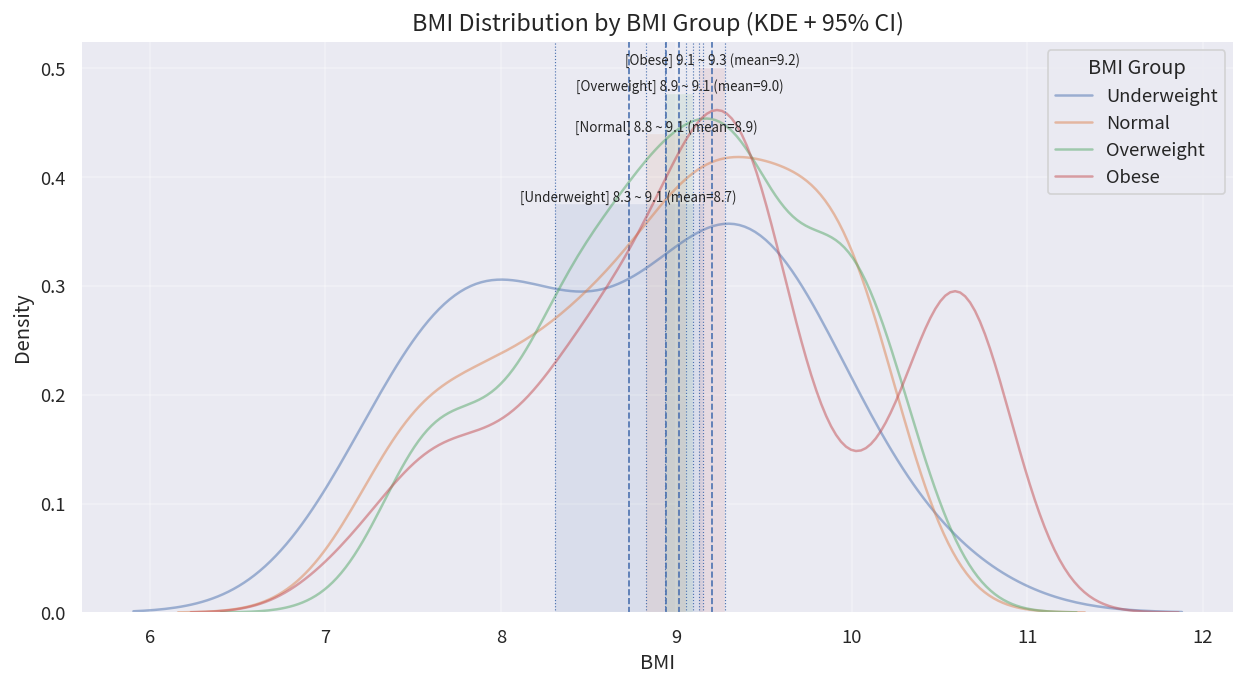

In [204]:
from math import sqrt
from scipy.stats import t

# 1) 그래프 초기화
width_px  = 1280
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    series = data[c].dropna()   # NaN 제거

    # KDE Plot
    sb.kdeplot(x=series, fill=False, alpha=0.5, label=c)

    # 신뢰구간 계산
    clevel = 0.95
    dof = len(series) - 1
    sp_mean = series.mean()
    sp_std = series.std(ddof=1)
    sp_std_error = sp_std / sqrt(len(series))

    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    # 시각화
    ax.axvline(cmin, linestyle=':', linewidth=0.7)
    ax.axvline(cmax, linestyle=':', linewidth=0.7)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)

    ax.text(
        x=(cmax + cmin) / 2,
        y=ymax,
        s=f"[{c}] {cmin:.1f} ~ {cmax:.1f} (mean={sp_mean:.1f})",
        ha='center',
        va='bottom',
        fontsize=8
    )

# 3) 그래프 꾸미기
ax.set_title('BMI Distribution by BMI Group (KDE + 95% CI)', fontsize=14, fontweight='bold')
ax.set_xlabel('BMI')
ax.grid(True, alpha=0.3)
ax.legend(title='BMI Group')

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


In [205]:
from scipy.stats import normaltest, bartlett, levene
from pandas import DataFrame

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    series = data[c].dropna()   # ⭐ 반드시 NaN 제거

    s, p = normaltest(series)

    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })

    normal_dist = normal_dist and normalize


# 변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns) > 1:
    if normal_dist:
        n = "Bartlett"               # 정규성 충족 시
        s, p = bartlett(*[data[c].dropna() for c in data.columns])
    else:
        n = "Levene"                 # 정규성 미충족 시
        s, p = levene(*[data[c].dropna() for c in data.columns], center="median")

    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index("field")
report_df


,statistic,p-value,result
field,,,
Underweight,2.579410,2.753520e-01,True
Normal,28.984171,5.083551e-07,False
Overweight,27.472395,1.082543e-06,False
Obese,42.870888,4.905745e-10,False
Levene,5.380510,1.107184e-03,False


> BMI 구간별 의료비에 대해 대부분 정규성 검정 결과는 충족되지 않았고,
Levene 검정 결과 등분산성 가정도 충족되지 않았다.
표본 수가 충분히 크므로 분산분석을 수행할 수 있으며,
분포의 왜도를 고려하여 Welch ANOVA를 사용하였다.

🔹 가설 설정
| 구분            | 내용                                             |
| ------------- | ---------------------------------------------- |
| **귀무가설 (H₀)** | BMI 구간별 평균 의료비는 모두 같다 |
| **대립가설 (H₁)** | 적어도 한 연령대의 평균 의료비는 다른 연령대와 다르다                 |


In [208]:
import pingouin as pg

# 1️⃣ ANOVA 전용 데이터프레임 생성
df_bmi_anova = df_plot2[['bmi_group', 'log_charges']].dropna().copy()
df_bmi_anova['bmi_group'] = df_bmi_anova['bmi_group'].astype('category')

# 2️⃣ Welch ANOVA 수행
anova_result = pg.welch_anova(
    data=df_bmi_anova,
    dv='log_charges',
    between='bmi_group'
)

# 3️⃣ 결과 추출
s = anova_result['F'].iloc[0]
p = anova_result['p-unc'].iloc[0]

# 4️⃣ 결과 출력
print(
    "statistic: {0:.3f}, p-value: {1:.3e}, {2}가설 채택"
    .format(s, p, "대립" if p <= 0.05 else "귀무")
)

anova_result


statistic: 7.445, p-value: 1.650e-04, 대립가설 채택


,Source,ddof1,ddof2,F,p-unc,np2
0,bmi_group,3,90.025052,7.445034,0.000165,0.016626


log(charges)를 기준으로 보았을 때, BMI 그룹에 따라 평균 의료비는 통계적으로 유의미하게 달라지며,
BMI 그룹은 의료비 수준을 설명하는 중요한 요인으로 나타났다.


| 항목         |                              값 | 해석                                |
| ---------- | -----------------------------: | --------------------------------- |
| **가설 검정**  | p-value = 1.65 × 10⁻⁴ (< 0.05) | 귀무가설(H₀)을 기각하고 대립가설(H₁)을 채택       |
| **통계적 의미** |                       F = 7.45 | BMI 그룹 간 평균 log(의료비) 차이가 통계적으로 유의 |
| **효과 크기**  |                   np² = 0.0166 | BMI 그룹의 영향은 **작음(small) 수준**      |


- Welch ANOVA 결과 연령대별 평균 의료비 차이가 유의하게 나타나 사후검정을 수행하였다.
- 등분산 가정을 필요로 하지 않는 Games–Howell 검정을 사용하였다. 

In [209]:
# df_age_anova: ['age_group', 'charges'] 포함된 데이터프레임
gh_df = pg.pairwise_gameshowell(
    data=df_bmi_anova,
    dv='log_charges',
    between='bmi_group'
)

gh_df

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Underweight,Normal,8.727876,8.940812,-0.212936,0.209202,-1.017849,22.106056,0.740884,-0.248880
1,Underweight,Overweight,8.727876,9.017199,-0.289323,0.205466,-1.408130,20.578034,0.508619,-0.359282
2,Underweight,Obese,8.727876,9.204177,-0.476301,0.204802,-2.325665,20.314391,0.125057,-0.482730
3,Normal,Overweight,8.940812,9.017199,-0.076387,0.069673,-1.096362,445.816546,0.691951,-0.093329
4,Normal,Obese,8.940812,9.204177,-0.263365,0.067690,-3.890740,433.217287,0.000666,-0.275208
5,Overweight,Obese,9.017199,9.204177,-0.186978,0.055072,-3.395182,939.337275,0.003978,-0.201886


<사후검정 결과 해설>

1️⃣ Underweight vs Normal
| 항목                |                    값 | 해석           |
| ----------------- | -------------------: | ------------ |
| mean(Underweight) |                8.728 | 저체중          |
| mean(Normal)      |                8.941 | 정상           |
| diff              |               -0.213 | Normal이 더 높음 |
| p-value           |                0.741 | 유의하지 않음      |
| Hedges’ g         |                -0.25 | 작은 효과        |
| **결론**            | Normal ≈ Underweight | 의료비 차이 없음    |



2️⃣ Underweight vs Overweight
| 항목                |                        값 | 해석               |
| ----------------- | -----------------------: | ---------------- |
| mean(Underweight) |                    8.728 | 저체중              |
| mean(Overweight)  |                    9.017 | 과체중              |
| diff              |                   -0.289 | Overweight가 더 높음 |
| p-value           |                    0.509 | 유의하지 않음          |
| Hedges’ g         |                    -0.36 | 작은~중간 효과         |
| **결론**            | Overweight ≈ Underweight | 통계적 차이 없음        |


3️⃣ Underweight vs Obese
| 항목                |                   값 | 해석            |
| ----------------- | ------------------: | ------------- |
| mean(Underweight) |               8.728 | 저체중           |
| mean(Obese)       |               9.204 | 비만            |
| diff              |              -0.476 | Obese가 더 높음   |
| p-value           |               0.121 | 유의하지 않음       |
| Hedges’ g         |               -0.48 | 중간 효과         |
| **결론**            | Obese ≥ Underweight | 증가 경향 있으나 불확실 |



4️⃣ Normal vs Overweight
| 항목               |                   값 | 해석        |
| ---------------- | ------------------: | --------- |
| mean(Normal)     |               8.941 | 정상        |
| mean(Overweight) |               9.017 | 과체중       |
| diff             |              -0.076 | 차이 매우 작음  |
| p-value          |               0.692 | 유의하지 않음   |
| Hedges’ g        |               -0.09 | 효과 거의 없음  |
| **결론**           | Normal ≈ Overweight | 의료비 수준 유사 |


5️⃣ Normal vs Obese ⭐
| 항목           |                  값 | 해석          |
| ------------ | -----------------: | ----------- |
| mean(Normal) |              8.941 | 정상          |
| mean(Obese)  |              9.204 | 비만          |
| diff         |             -0.263 | Obese가 더 높음 |
| p-value      |        6.66 × 10⁻⁴ | **유의**      |
| Hedges’ g    |              -0.28 | 작은~중간 효과    |
| **결론**       | **Obese > Normal** | 비만에서 의료비 증가 |


6️⃣ Overweight vs Obese ⭐
| 항목               |                      값 | 해석          |
| ---------------- | ---------------------: | ----------- |
| mean(Overweight) |                  9.017 | 과체중         |
| mean(Obese)      |                  9.204 | 비만          |
| diff             |                 -0.187 | Obese가 더 높음 |
| p-value          |            3.98 × 10⁻³ | **유의**      |
| Hedges’ g        |                  -0.20 | 작은 효과       |
| **결론**           | **Obese > Overweight** | 비만 단계에서 증가  |


🔢 서열 요약

Underweight ≈ Normal ≈ Overweight < Obese



Games–Howell 사후검정 결과, BMI 그룹 간 의료비 차이는 주로 비만(Obese) 그룹과 다른 BMI 그룹 간 비교에서 유의하게 나타났다. 정상 및 과체중 그룹 간에는 유의한 차이가 관찰되지 않았으나, 비만 그룹은 정상 및 과체중 그룹보다 평균 log(의료비)가 유의하게 높았다. 이는 BMI가 연속적으로 의료비를 증가시키기보다는, 비만 단계에 진입하면서 의료비 부담이 구조적으로 증가함을 시사한다.


#### 3-2 그렇다면 흡연율은?

- 성별에 따른 흡연율
  
| 성별     | 흡연율 (%) |
| ------ | ------: |
| Female |    17.4 |
| Male   |    23.5 |


- 지역에 따른 흡연율 
  
| 지역        | 흡연율 (%) |
| --------- | ------: |
| Northeast |    20.7 |
| Northwest |    17.8 |
| Southeast |    25.0 |
| Southwest |    17.8 |


- BMI 그룹에 따른 흡연율 
  
| BMI 그룹      | 흡연율 (%) |
| ----------- | ------: |
| Underweight |    25.0 |
| Normal      |    22.2 |
| Overweight  |    19.2 |
| Obese       |    20.5 |


- 연령대에 따른 흡연율
  
| 연령대   |        흡연율 (%) |
| ----- | -------------: |
| 18–24 |           21.6 |
| 25–34 |           20.7 |
| 35–44 |           23.5 |
| 45–64 |           18.3 |


C:\Users\itwill\AppData\Local\Temp\ipykernel_396\300778106.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_col, dropna=False)
C:\Users\itwill\AppData\Local\Temp\ipykernel_396\300778106.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_col, dropna=False)


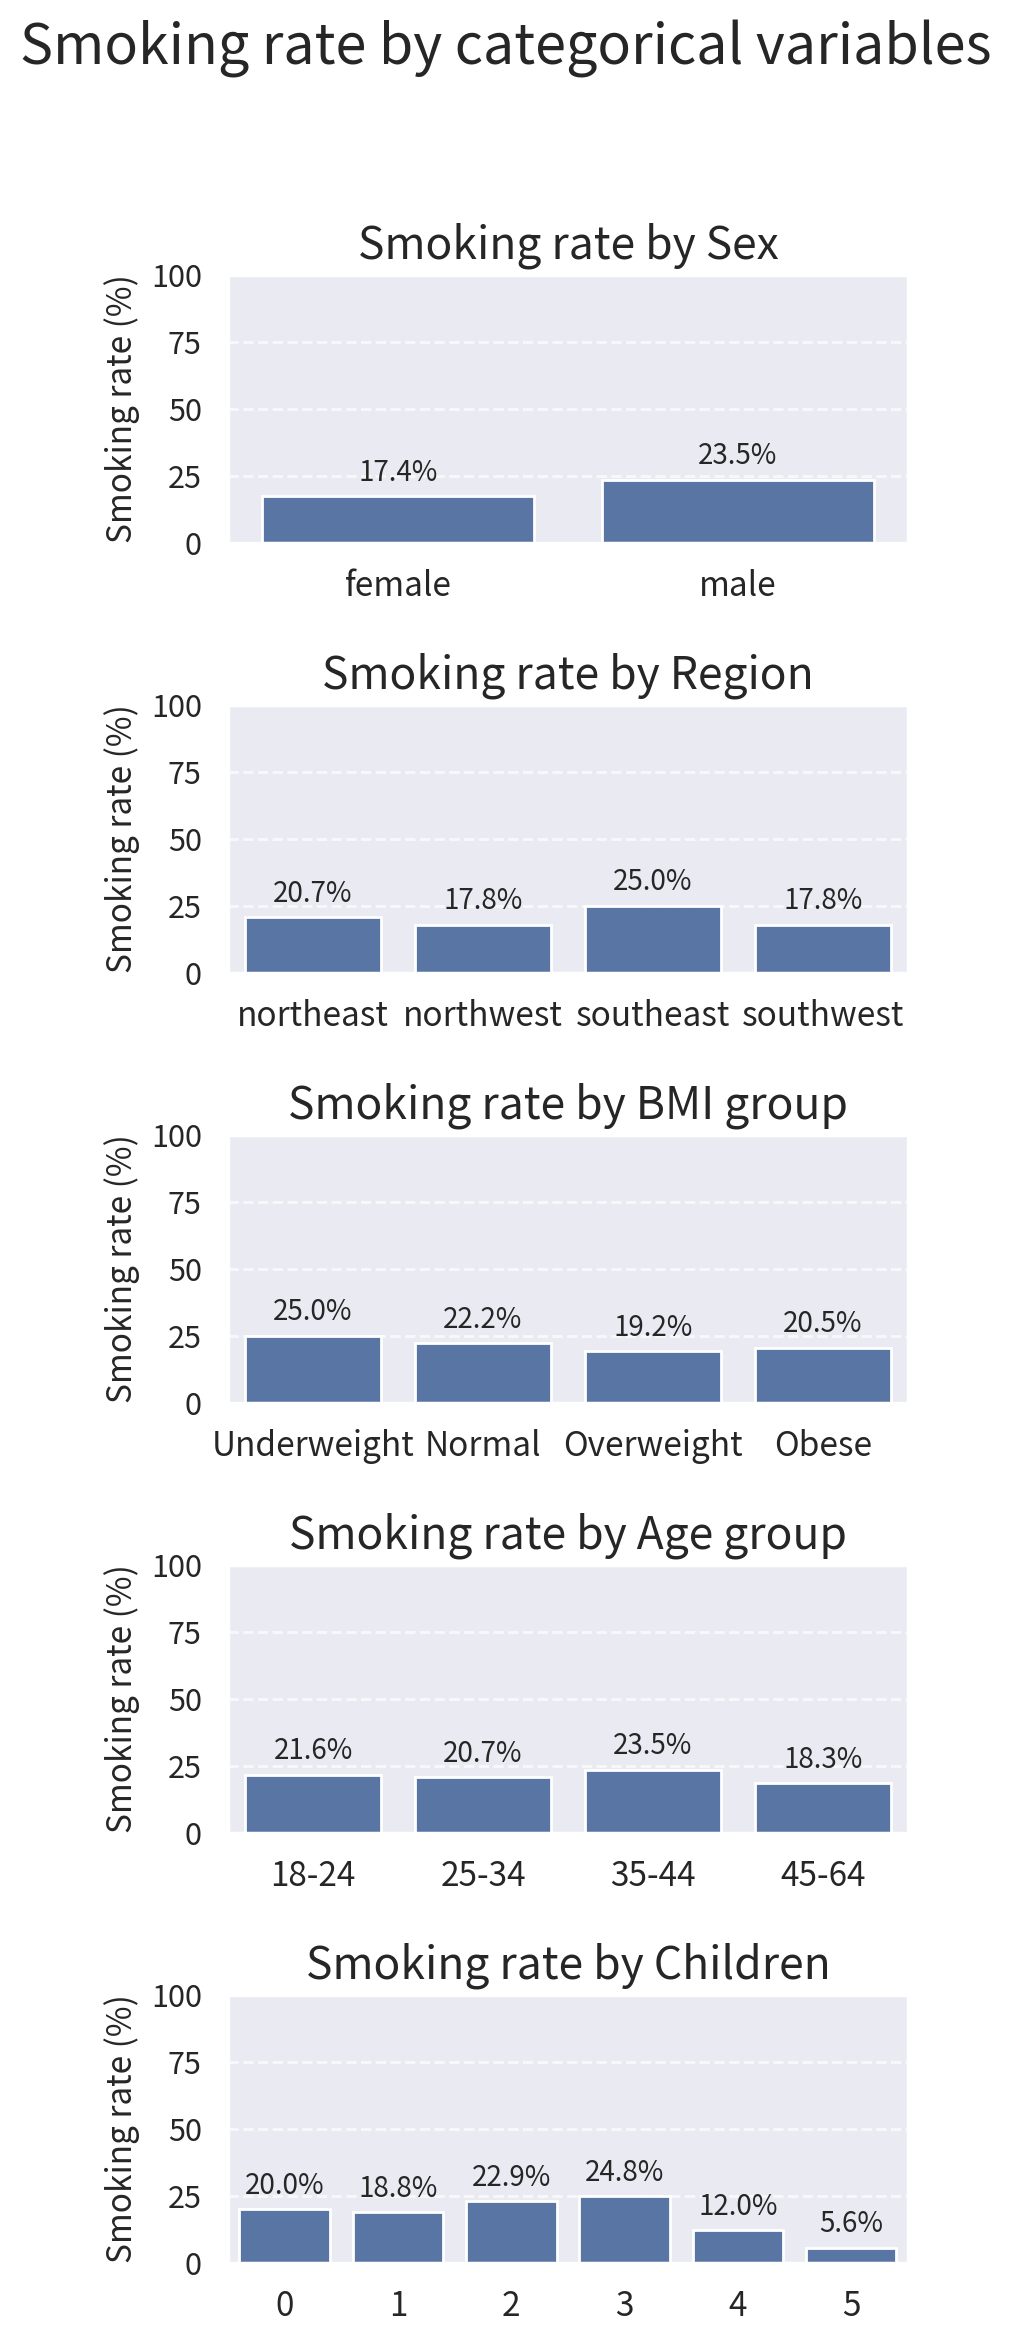

In [189]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# 0) 흡연율(%) 계산 함수
def make_smoke_rate_df(df, group_col, smoker_col='smoker'):
    out = (
        df.assign(smoke_yes=df[smoker_col].eq('yes').astype(int))
          .groupby(group_col, dropna=False)
          .agg(total=('smoke_yes', 'size'),
               smokers=('smoke_yes', 'sum'))
          .reset_index()
    )
    out['smoke_rate'] = out['smokers'] / out['total'] * 100
    return out


# 1) 변수별 흡연율 df 만들기
sex_rate_df      = make_smoke_rate_df(df_plot2, 'sex')
region_rate_df   = make_smoke_rate_df(df_plot2, 'region')
bmi_rate_df      = make_smoke_rate_df(df_plot2, 'bmi_group')
age_rate_df      = make_smoke_rate_df(df_plot2, 'age_group')
children_rate_df = make_smoke_rate_df(df_plot2, 'children')


# (선택) 보기 좋게 범주 순서 고정
bmi_order = ['Underweight', 'Normal', 'Overweight', 'Obese']
age_order = ['18-24', '25-34', '35-44', '45-64']  # 네가 65+ 만들었으면
# children은 숫자라 자동 정렬되는데 혹시 문자열이면 아래처럼:
# children_order = sorted(children_rate_df['children'].unique())

# 2) 그래프 초기화 (rows=5)
width_px = 900
height_px = 2400
rows, cols = 5, 1
figsize = (width_px / 200, height_px / 200)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=200)

plot_info = [
    (sex_rate_df,      'sex',       'Smoking rate by Sex',       None),
    (region_rate_df,   'region',    'Smoking rate by Region',    None),
    (bmi_rate_df,      'bmi_group', 'Smoking rate by BMI group', bmi_order),
    (age_rate_df,      'age_group', 'Smoking rate by Age group', age_order),
    (children_rate_df, 'children',  'Smoking rate by Children',  None),
]

# 3) barplot 그리기 (y='smoke_rate')
for i, (df, x_col, title, order) in enumerate(plot_info):
    sb.barplot(
        data=df,
        x=x_col,
        y='smoke_rate',
        order=order,
        ax=ax[i]
    )

    ax[i].grid(axis='y', linestyle='--', alpha=0.7)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Smoking rate (%)', fontsize=12)
    ax[i].set_title(title, fontsize=16, fontweight='bold')
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].tick_params(axis='y', labelsize=11)

    # y축 범위 (0~100% 중 필요한 범위로 보기 좋게)
    ax[i].set_ylim(0, 100)

    # (선택) 막대 위에 퍼센트 표시
    for p in ax[i].patches:
        h = p.get_height()
        ax[i].annotate(f'{h:.1f}%',
                       (p.get_x() + p.get_width()/2, h),
                       ha='center', va='bottom', fontsize=10,
                       xytext=(0, 3), textcoords='offset points')

fig.suptitle('Smoking rate by categorical variables', fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
plt.close()


#### 3-3 그렇다면 가장 크게 작용하는 변수는? (생략)
> 작용 효과는 후반에서 회귀 분석을 진행해야 명확하게 나온다고 판단함


#### 3-4 상관분석

1. 주요 작업
   - 연속형 변수 위주로 'age', 'bmi', 'children', 'log_charges' 상관행렬 생성 하여 시각화, VIF 점검
   - children 은 이산형 변수이므로 목적에 따라 연속형/범주형 변수로 쓰일 수 있다고 판단함 (해당 분석에서는 연속형으로서 사용)


2. 상관성 확인 
   - z score 기준으로 outlier 확인 시, 이상치가 확인되어 스피어만 상관계수 사용 

| 변수              |   age |   bmi | children | log_charges |
| --------------- | ----: | ----: | -------: | ----------: |
| **age**         | 1.000 | 0.108 |    0.057 |       0.534 |
| **bmi**         | 0.108 | 1.000 |    0.016 |       0.119 |
| **children**    | 0.057 | 0.016 |    1.000 |       0.133 |
| **log_charges** | 0.534 | 0.119 |    0.133 |       1.000 |



3. VIF 확인
   - VIF 분석 결과, age, bmi, children의 VIF 값은 모두 1.0~1.02 수준으로 나타나
    다중공선성 문제는 전혀 관찰되지 않았다.\

   - 이는 다음 두 가지 이유에 기인한다.
    독립변수 간 상관계수가 전반적으로 낮아 변수 간 정보 중복이 거의 없고,
    각 변수는 의료비에 대해 서로 다른 측면(연령, 건강 상태, 가족 구성)을 설명하기 때문이다.
    따라서 본 분석에서는 모든 변수를 안정적으로 회귀 모델에 포함할 수 있다.

In [190]:
df_corr = df_plot2.copy()

- 테이블 확인

In [191]:
df_corr

,age,sex,bmi,children,smoker,region,charges,log_charges,age_group,bmi_group
0,19,female,27.900,0,yes,southwest,16884.92400,9.734236,18-24,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,7.453882,18-24,Obese
2,28,male,33.000,3,no,southeast,4449.46200,8.400763,25-34,Obese
3,33,male,22.705,0,no,northwest,21984.47061,9.998137,25-34,Normal
4,32,male,28.880,0,no,northwest,3866.85520,8.260455,25-34,Overweight
...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,9.268755,45-64,Obese
1334,18,female,31.920,0,no,northeast,2205.98080,7.699381,18-24,Obese
1335,18,female,36.850,0,no,southeast,1629.83350,7.396847,18-24,Obese
1336,21,female,25.800,0,no,southwest,2007.94500,7.605365,18-24,Overweight


In [192]:
# 이상치와 왜도 검정
data = df_corr[['age', 'bmi', 'children', 'log_charges']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    # 로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count,
        'log_recommended': need_log,
    }

# 결과 dataframe 변환
results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 검정 결과
outlier_flag = len(results_df[results_df['outliers(|z|>3)'] > 0]) > 0


if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")


,original_skew,log_skew,outliers(|z|>3),log_recommended
age,0.055673,-0.988574,0,False
bmi,0.284047,-0.963062,4,False
children,0.93838,0.432129,18,False
log_charges,-0.089817,-0.59579,0,False


이상치가 발견되어 스피어만 상관계수 사용


In [193]:
cols = ['age', 'bmi', 'children', 'log_charges']

# 스피어만 상관행렬 + p-value 행렬
corr, pvals = spearmanr(df_corr[cols])

# DataFrame으로 정리
spearman_corr = pd.DataFrame(corr, index=cols, columns=cols)
spearman_pval = pd.DataFrame(pvals, index=cols, columns=cols)

spearman_corr, spearman_pval


(                  age       bmi  children  log_charges
 age          1.000000  0.107736  0.056992     0.534392
 bmi          0.107736  1.000000  0.015607     0.119396
 children     0.056992  0.015607  1.000000     0.133339
 log_charges  0.534392  0.119396  0.133339     1.000000,
                       age       bmi      children   log_charges
 age          0.000000e+00  0.000079  3.711959e-02  1.130692e-99
 bmi          7.859093e-05  0.000000  5.684234e-01  1.192606e-05
 children     3.711959e-02  0.568423  0.000000e+00  9.846806e-07
 log_charges  1.130692e-99  0.000012  9.846806e-07  0.000000e+00)

In [194]:
# 사용할 변수
cols = ['age', 'bmi', 'children', 'log_charges']

# 상관계수 선택 (이전에 이상치/왜도 검사 결과 → Spearman 권장)
chosen = 'spearman'   # 또는 'pearson'

corr_matrix = df_corr[cols].corr(method=chosen)
corr_matrix


,age,bmi,children,log_charges
age,1.000000,0.107736,0.056992,0.534392
bmi,0.107736,1.000000,0.015607,0.119396
children,0.056992,0.015607,1.000000,0.133339
log_charges,0.534392,0.119396,0.133339,1.000000


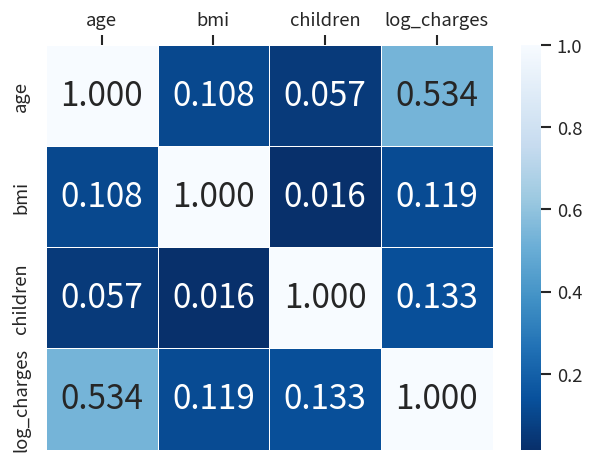

In [195]:
# 1) 그래프 초기화
width_px  = 650          # 그래프 가로 크기
height_px = 500          # 그래프 세로 크기
rows = 1                 # 그래프 행 수
cols = 1                 # 그래프 열 수

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) heatmap 그리기
sb.heatmap(
    data=corr_matrix,
    annot=True,
    fmt="0.3f",
    linewidth=0.5,
    cmap="Blues_r",
    annot_kws={"size": 20}
)

# 3) 그래프 꾸미기
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()      # x축의 변수 이름을 상단으로 이동

# 4) 출력
plt.tight_layout()       # 여백 제거
plt.show()               # 그래프 화면 출력
plt.close()              # 그래프 작업 종료


In [196]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# 독립변수 (log_charges는 종속변수이므로 제외)
X = origin[['age', 'bmi', 'children']].dropna()

# 상수항 추가 (VIF 계산 시 관례)
X_const = np.column_stack([np.ones(len(X)), X])


In [197]:
vif_df = pd.DataFrame()
vif_df['variable'] = ['const'] + X.columns.tolist()
vif_df['VIF'] = [
    variance_inflation_factor(X_const, i)
    for i in range(X_const.shape[1])
]

vif_df


,variable,VIF
0,const,31.954929
1,age,1.013816
2,bmi,1.012152
3,children,1.001874


#### 3-4-2 “어떤 변수가 의료비와 가장 가까울까?” (뒤에 회귀 분석에서 설명할 수 있을것이라 판단 / 생략)

### 4. 회귀분석 
1. 회귀분석 진행
2. 선형회귀 기본가정 4가지 확인
3. 만족못하는 것 전처리
4. 회귀분석
5. 기본가정 재확인
6. 다중공선성 처리
7. 회귀분석 다시진행
8. 유의하지 않는 거 처리
9. 회귀분석 진행
10. 선형 회귀분석 기본가정 4가지 만족여부 확인


In [213]:
df_analysis=df_plot2.copy()

In [214]:
df_analysis

,age,sex,bmi,children,smoker,region,charges,log_charges,age_group,bmi_group
0,19,female,27.900,0,yes,southwest,16884.92400,9.734236,18-24,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,7.453882,18-24,Obese
2,28,male,33.000,3,no,southeast,4449.46200,8.400763,25-34,Obese
3,33,male,22.705,0,no,northwest,21984.47061,9.998137,25-34,Normal
4,32,male,28.880,0,no,northwest,3866.85520,8.260455,25-34,Overweight
...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,9.268755,45-64,Obese
1334,18,female,31.920,0,no,northeast,2205.98080,7.699381,18-24,Obese
1335,18,female,36.850,0,no,southeast,1629.83350,7.396847,18-24,Obese
1336,21,female,25.800,0,no,southwest,2007.94500,7.605365,18-24,Overweight


####  age , bmi 연속형으로 처리한 모델
 1) 기본 모델 : log charges 를 종속 변수로 삼아  QQ PLOT , 선형성, 잔차의 독립성 , 등분산성 확인
    > QQ PLOT 불안정 , 선형성 위반 , 이분산성 존재

 2) BOX COX : charges 원본 데이터에 box cox 적용 
    > 선형성 위반 , 이분산성 존재 

 3) bmi,age 연속형 변수에 로그 적용
    > 선형성 위반 , 이분산성 존재 

 4) bmi,age 연속형 변수에 제곱근 적용
    > 선형성 위반 , 이분산성 존재 

 5) 상호작용항 적용
    >  선형성 위반 , 이분산성 존재 

 6) Gamma GLM 모델 채택 

 #### 1) 기본 모델 : log charges 를 종속 변수로 삼아  QQ PLOT , 선형성, 잔차의 독립성 , 등분산성 확인
    > QQ PLOT 불안정 , 선형성 위반 , 이분산성 존재

In [ ]:
model = ols('log_charges ~ age + C(sex) + bmi + children + C(smoker) + C(region)', data = df_analysis).fit()

- model QQ PLOT
 1. 정규성 검정, 결과 : 정규성 만족 안함, 하지만 qq플롯으로본 결과 비교적 회귀직선에 따르므로 회귀분석 그냥 진행가능

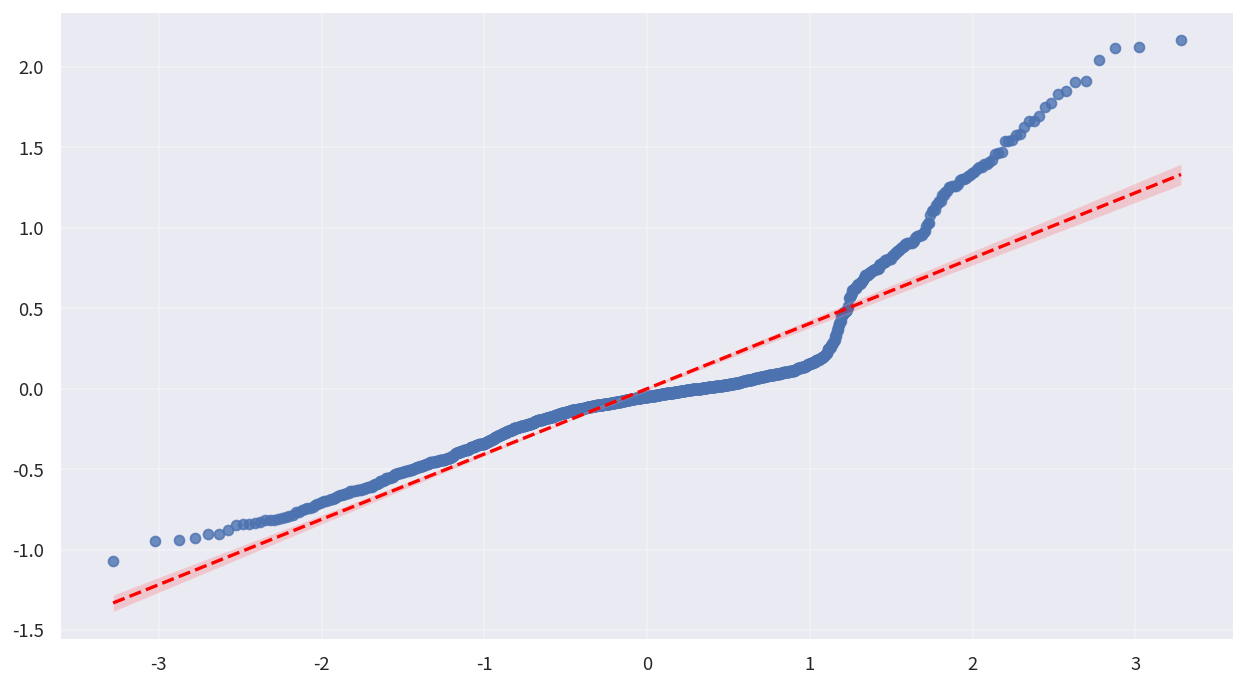

In [ ]:
(x, y), _ = probplot(model.resid)

width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) regplot 그리기
sb.regplot(x=x, y=y, line_kws={
"color": "red",
"linestyle": "--",   
"linewidth": 2
            })
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)           

plt.tight_layout()      
plt.show()              
plt.close()             

In [ ]:
model = ols('log_charges ~ age + C(sex) + bmi + children + C(smoker) + C(region)', data = df_analysis).fit()
stats.shapiro(model.resid)

ShapiroResult(statistic=np.float64(0.8372686117062332), pvalue=np.float64(6.754373396999853e-35))

2. 선형성 검정, 결과 : 위배 가능성 있음

In [ ]:
reset_res = linear_reset(model, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 287.0048
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


3.  잔차의 독립성 검정, 결과 : 독립성 만족

In [ ]:
dw = durbin_watson(model.resid)

if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"

print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)

Durbin–Watson: 2.046
잔차는 독립성을 만족함 (자기상관 없음)


4. 등분산성 검정, 결과 : 등분산 아님

In [ ]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 10.151, p-value = 0.000
이분산성 존재(등분산 아님)


 2) BOX COX : charges 원본 데이터에 box cox 적용 
    > 선형성 위반 , 이분산성 존재 

- charges_boxcox 변수 생성

In [229]:
df_analysis2 = df_analysis.copy()

In [240]:
df_analysis2

,age,sex,bmi,children,smoker,region,charges,log_charges,age_group,bmi_group,charges_bc,age_log,bmi_log
0,19,female,27.900,0,yes,southwest,16884.92400,9.734236,18-24,Overweight,12.128980,2.944439,3.328627
1,18,male,33.770,1,no,southeast,1725.55230,7.453882,18-24,Obese,8.808597,2.890372,3.519573
2,28,male,33.000,3,no,southeast,4449.46200,8.400763,25-34,Obese,10.147521,3.332205,3.496508
3,33,male,22.705,0,no,northwest,21984.47061,9.998137,25-34,Normal,12.534951,3.496508,3.122585
4,32,male,28.880,0,no,northwest,3866.85520,8.260455,25-34,Overweight,9.945637,3.465736,3.363149
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,9.268755,45-64,Obese,11.424197,3.912023,3.433019
1334,18,female,31.920,0,no,northeast,2205.98080,7.699381,18-24,Obese,9.150491,2.890372,3.463233
1335,18,female,36.850,0,no,southeast,1629.83350,7.396847,18-24,Obese,8.729683,2.890372,3.606856
1336,21,female,25.800,0,no,southwest,2007.94500,7.605365,18-24,Overweight,9.019132,3.044522,3.250374


In [ ]:
y = df_analysis2['charges']
y_bc, lam = stats.boxcox(y)
df_analysis2['charges_bc'] = y_bc
model = ols('charges_bc ~ age + C(sex) + bmi + children + C(smoker) + C(region)', data = df_analysis2).fit()
stats.shapiro(model3.resid)

ShapiroResult(statistic=np.float64(0.8294801902859807), pvalue=np.float64(1.5794296661975697e-35))

In [ ]:
reset_res = linear_reset(model, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 212.8729
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


In [ ]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 11.392, p-value = 0.000
이분산성 존재(등분산 아님)


3) bmi,age 연속형 변수에 로그 적용
    > 선형성 위반 , 이분산성 존재 

In [ ]:
df_analysis2['age_log'] = np.log(df_analysis2['age'])
df_analysis2['bmi_log'] = np.log(df_analysis2['bmi'])
model = ols('log_charges ~ age_log + C(sex) + bmi_log + children + C(smoker) + C(region)', data = df_analysis2).fit()

In [ ]:
reset_res = linear_reset(model, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 212.8729
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


In [ ]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 11.392, p-value = 0.000
이분산성 존재(등분산 아님)


 4) bmi,age 연속형 변수에 제곱근 적용
    > 선형성 위반 , 이분산성 존재 

In [ ]:
df_analysis2['age2'] = df_analysis2['age']**2
df_analysis2['bmi2'] = df_analysis2['bmi']**2
model = ols('log_charges ~ age2 + C(sex) + bmi2 + children + C(smoker) + C(region)', data = df_analysis2).fit()

In [ ]:
reset_res = linear_reset(model, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 330.1316
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


In [ ]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 9.058, p-value = 0.000
이분산성 존재(등분산 아님)


 5) 상호작용항 적용
    >  선형성 위반 , 이분산성 존재 

In [246]:
df_analysis3 = df_analysis2.copy()
df_analysis3 = pd.get_dummies(df_analysis3, dtype = int, drop_first=True)

In [247]:
df_analysis3.columns

Index(['age', 'bmi', 'children', 'charges', 'log_charges', 'charges_bc',
       'age_log', 'bmi_log', 'age2', 'bmi2', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest',
       'age_group_25-34', 'age_group_35-44', 'age_group_45-64',
       'bmi_group_Normal', 'bmi_group_Overweight', 'bmi_group_Obese'],
      dtype='object')

In [ ]:
df_analysis3['bmi_smoker_interaction'] = df_analysis3['bmi'] * df_analysis3['smoker_yes']
df_analysis3['age_smoker_interaction'] = df_analysis3['age'] * df_analysis3['smoker_yes']
ydfe.columns

 6) Gamma GLM 모델 채택 

####  model2 : age , bmi 범주형으로 처리한 모델
 > 여전히 선형성, 등분산성 충족 X 

In [ ]:
model = ols('log_charges ~ C(age_group) + C(sex) + C(bmi_group) + children + C(smoker) + C(region)', data = df_analysis).fit()

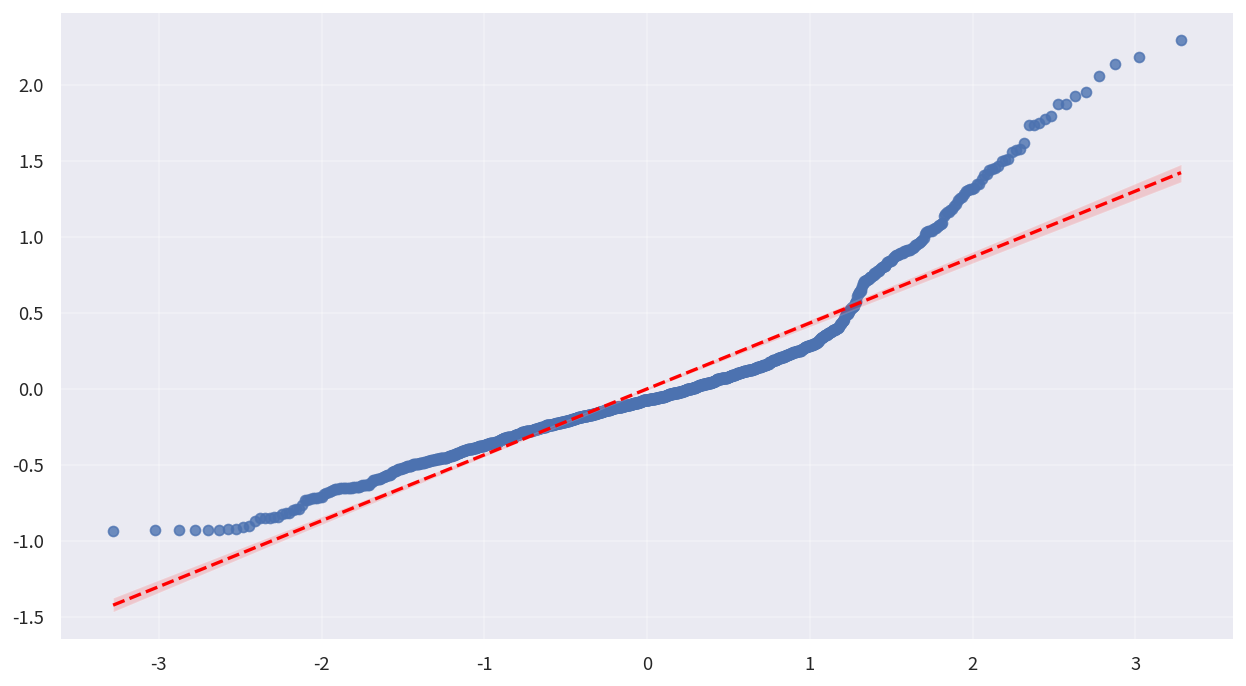

In [ ]:
(x, y), _ = probplot(model.resid)

width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) regplot 그리기
sb.regplot(x=x, y=y, line_kws={
"color": "red",
"linestyle": "--",   
"linewidth": 2
            })
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)           

plt.tight_layout()      
plt.show()              
plt.close()             

In [ ]:
model = ols('log_charges ~ C(age_group) + C(sex) + C(bmi_group) + children + C(smoker) + C(region)', data = df_analysis).fit()
stats.shapiro(model.resid)

ShapiroResult(statistic=np.float64(0.8880437401987866), pvalue=np.float64(4.6244497867035275e-30))

2. 선형성 검정, 결과 : 위배 가능성 있음

In [ ]:
reset_res = linear_reset(model, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 222.6735
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


3.  잔차의 독립성 검정, 결과 : 독립성 만족

In [ ]:
dw = durbin_watson(model.resid)

if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"

print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)

Durbin–Watson: 2.045
잔차는 독립성을 만족함 (자기상관 없음)


4. 등분산성 검정, 결과 : 등분산 아님

In [ ]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 9.850, p-value = 0.000
이분산성 존재(등분산 아님)


- model 2 를 기반으로 Gamma GLM 모형 대입

In [ ]:
import statsmodels.formula.api as smf
model_glm = smf.glm(
    formula='log_charges ~ C(age_group) + C(sex) + C(bmi_group) + children + C(smoker) + C(region)',
    data=df_analysis,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()
print(model_glm.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:            log_charges   No. Observations:                 1338
Model:                            GLM   Df Residuals:                     1325
Model Family:                   Gamma   Df Model:                           12
Link Function:                    log   Scale:                       0.0029508
Method:                          IRLS   Log-Likelihood:                -910.27
Date:                Thu, 15 Jan 2026   Deviance:                       3.7194
Time:                        15:11:29   Pearson chi2:                     3.91
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9242
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


### 5. 해석